In [1]:
import wecgrid
engine = wecgrid.Engine()
engine.case("IEEE_30_bus")
engine.load(["psse", "pypsa"]) 

PSS®E software initialized
PyPSA software initialized


In [2]:
engine.apply_wec(farm_name="WEC-FARM", size = 10, sim_id=2, bus_location=31, connecting_bus=1, model="RM3")

In [3]:
engine.simulate(load_curve=True)

PSS®E Simulating:  58%|█████▊    | 83/144 [00:02<00:01, 38.55step/s]

PyPSA Simulating: 100%|██████████| 144/144 [00:42<00:00,  3.37step/s]


Looking for WEC generators: ['31_1']
Available WEC generators in data: ['31_1']


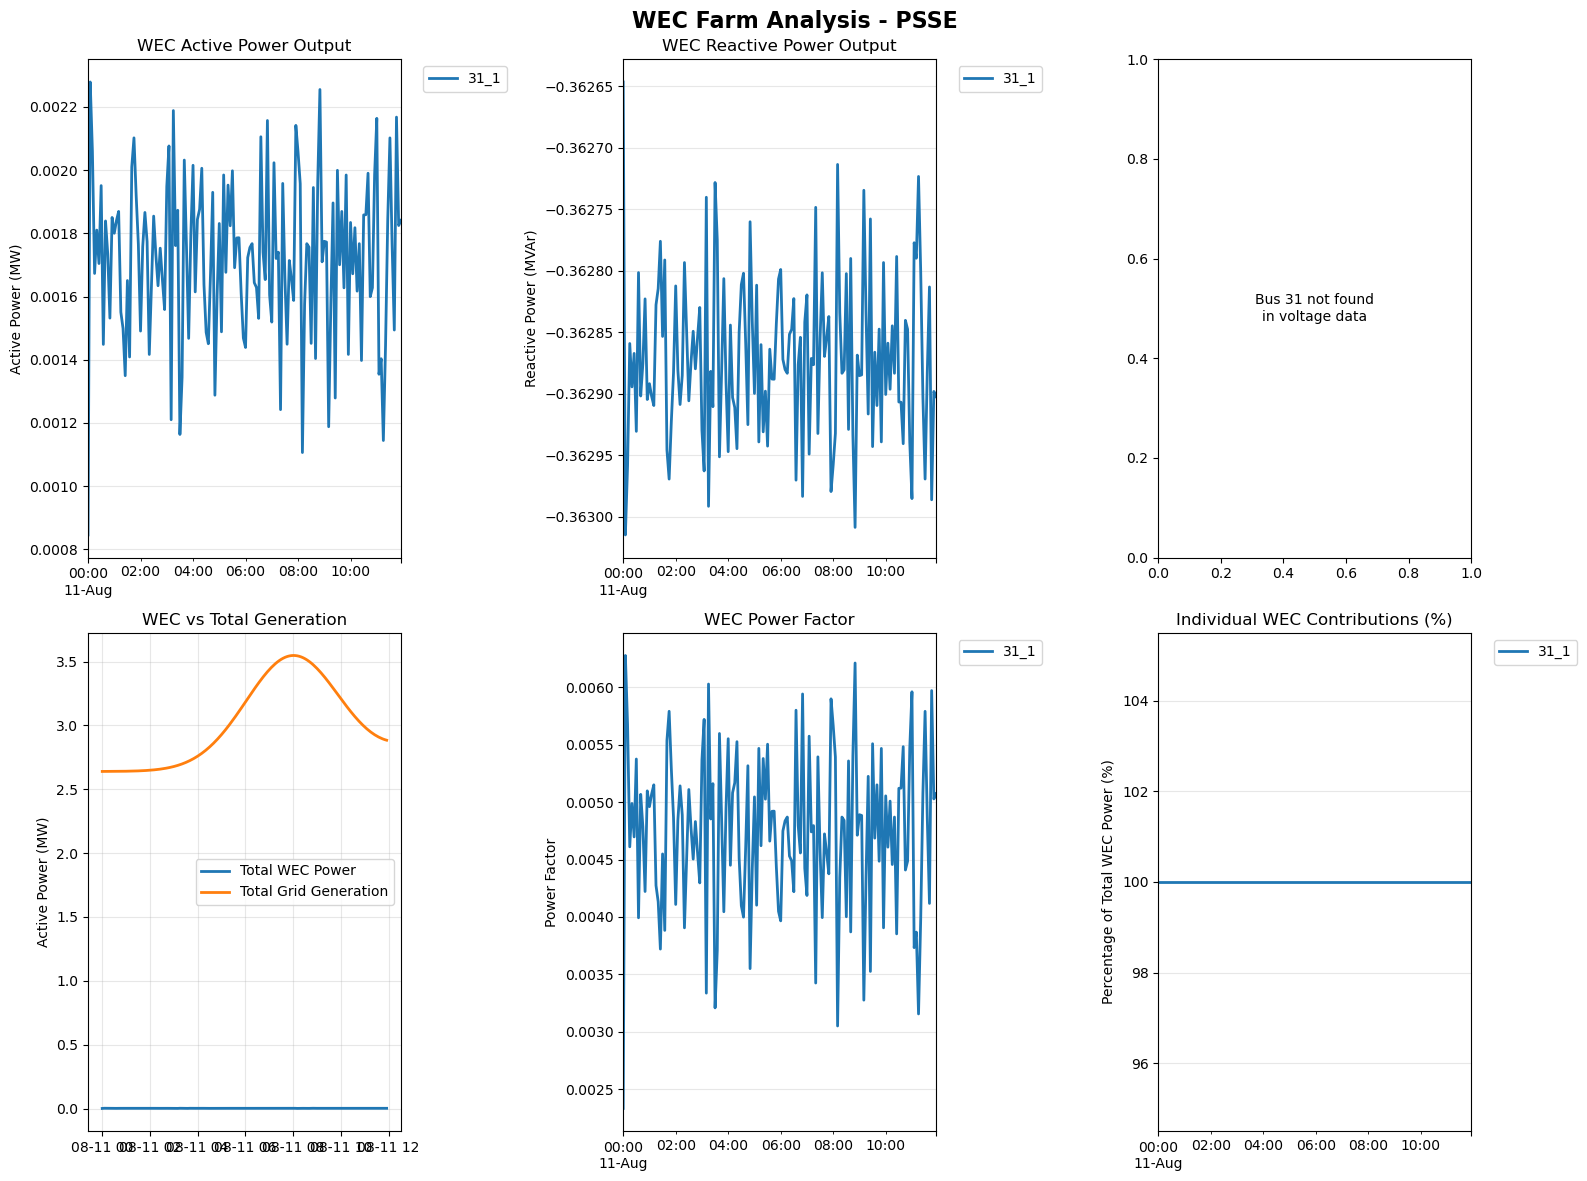

(<Figure size 1600x1200 with 6 Axes>,
 array([<AxesSubplot:title={'center':'WEC Active Power Output'}, ylabel='Active Power (MW)'>,
        <AxesSubplot:title={'center':'WEC Reactive Power Output'}, ylabel='Reactive Power (MVAr)'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'WEC vs Total Generation'}, ylabel='Active Power (MW)'>,
        <AxesSubplot:title={'center':'WEC Power Factor'}, ylabel='Power Factor'>,
        <AxesSubplot:title={'center':'Individual WEC Contributions (%)'}, ylabel='Percentage of Total WEC Power (%)'>],
       dtype=object))

In [4]:
engine.plot.plot_wec_analysis("psse")

In [ ]:
engine.wec_farms[0]

1

Plotting 7 components over 144 time steps


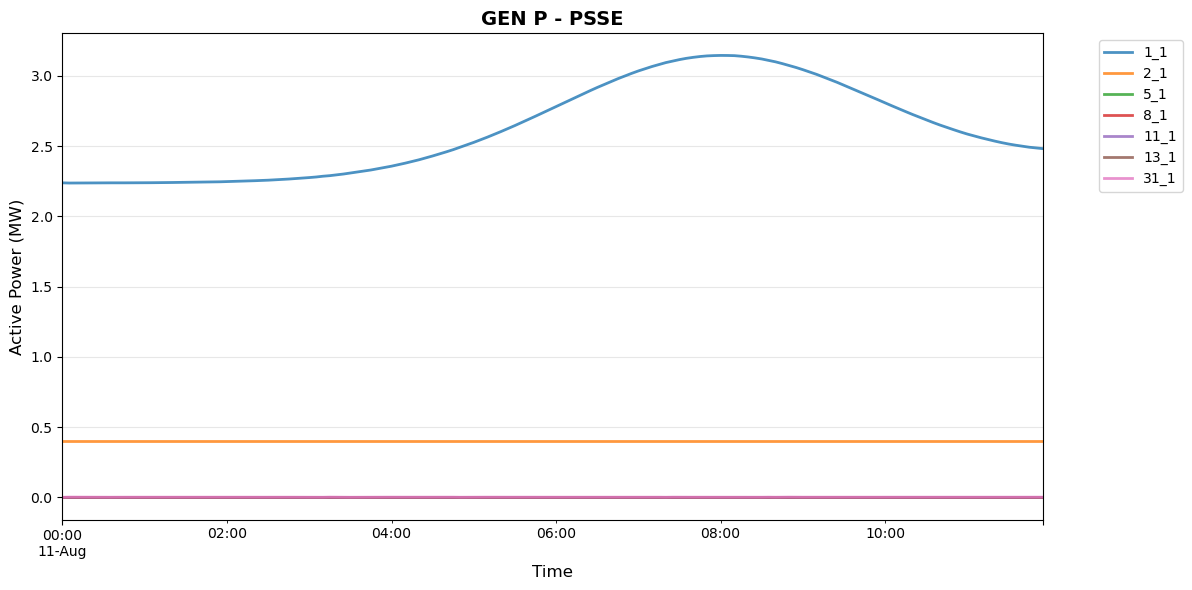

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'GEN P - PSSE'}, xlabel='Time', ylabel='Active Power (MW)'>)

In [4]:
engine.plot.plot_generator("psse", "p")

Plotting 31 components over 144 time steps


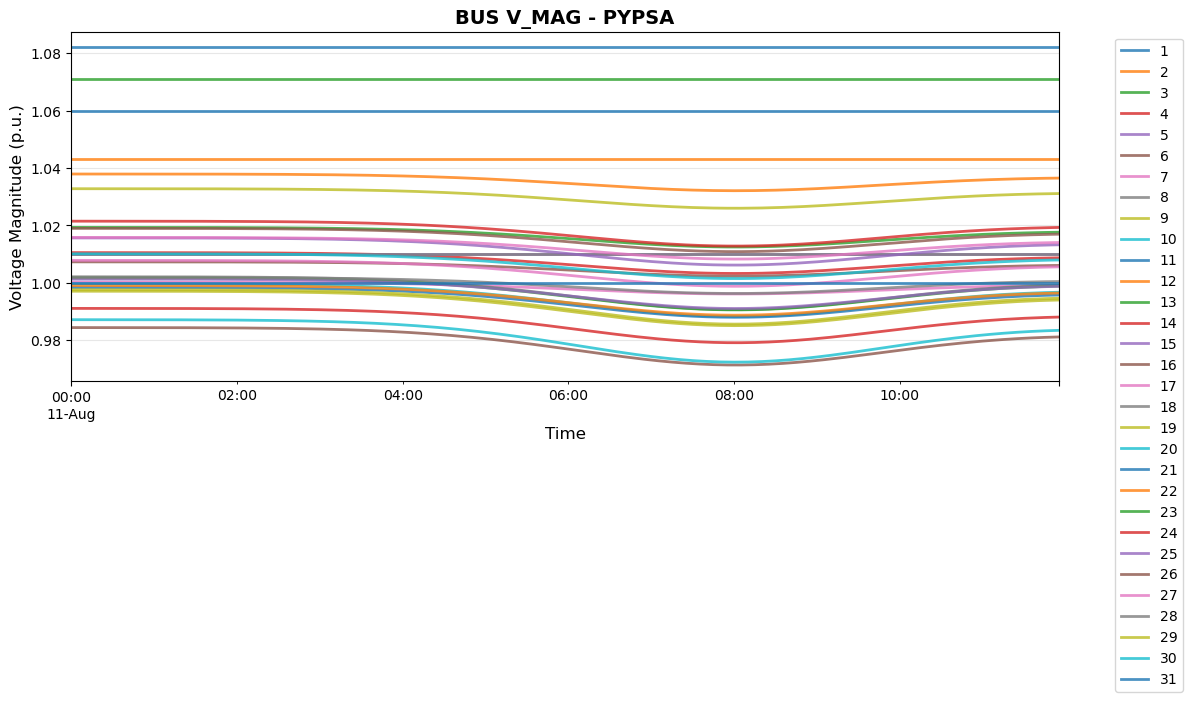

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'BUS V_MAG - PYPSA'}, xlabel='Time', ylabel='Voltage Magnitude (p.u.)'>)

In [5]:
engine.plot.plot_bus("pypsa", "v_mag")


=== PSSE Grid Overview ===

--- Generators ---
Plotting 7 components over 144 time steps


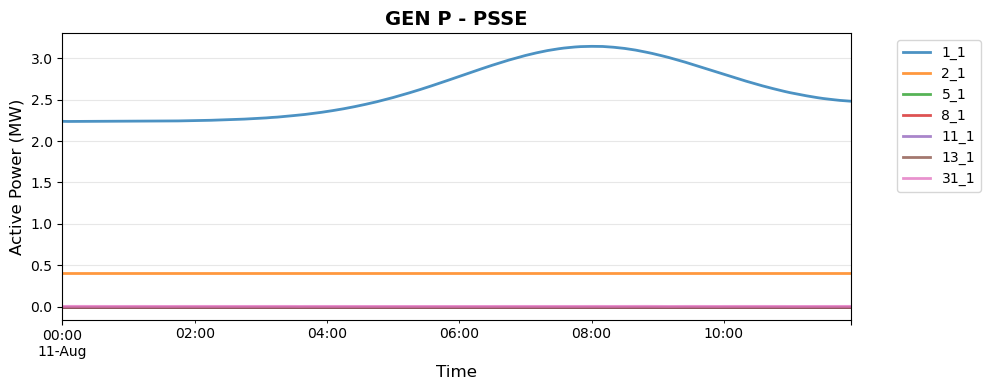


--- Bus Voltages ---
Plotting 31 components over 144 time steps


C:\Users\alexb\research\WEC-GRID\src\wecgrid\plot\wecgrid_plotter.py:143: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



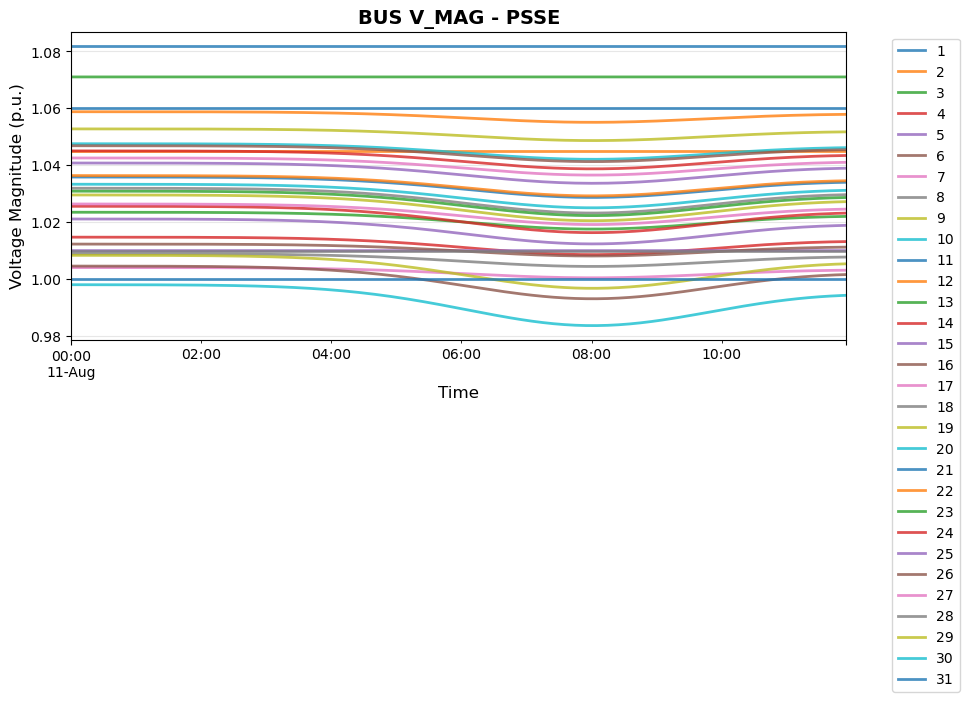


--- Line Loading ---
Plotting 38 components over 144 time steps


C:\Users\alexb\research\WEC-GRID\src\wecgrid\plot\wecgrid_plotter.py:143: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



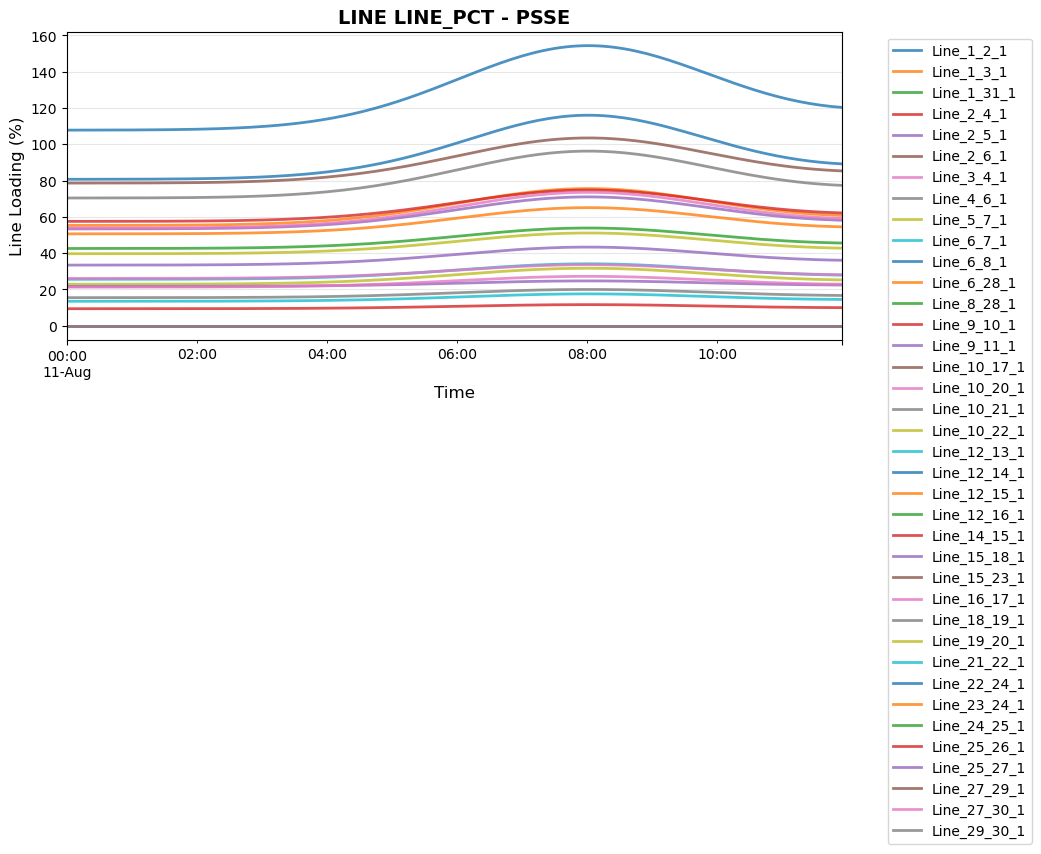

In [6]:
engine.plot.quick_overview("psse")

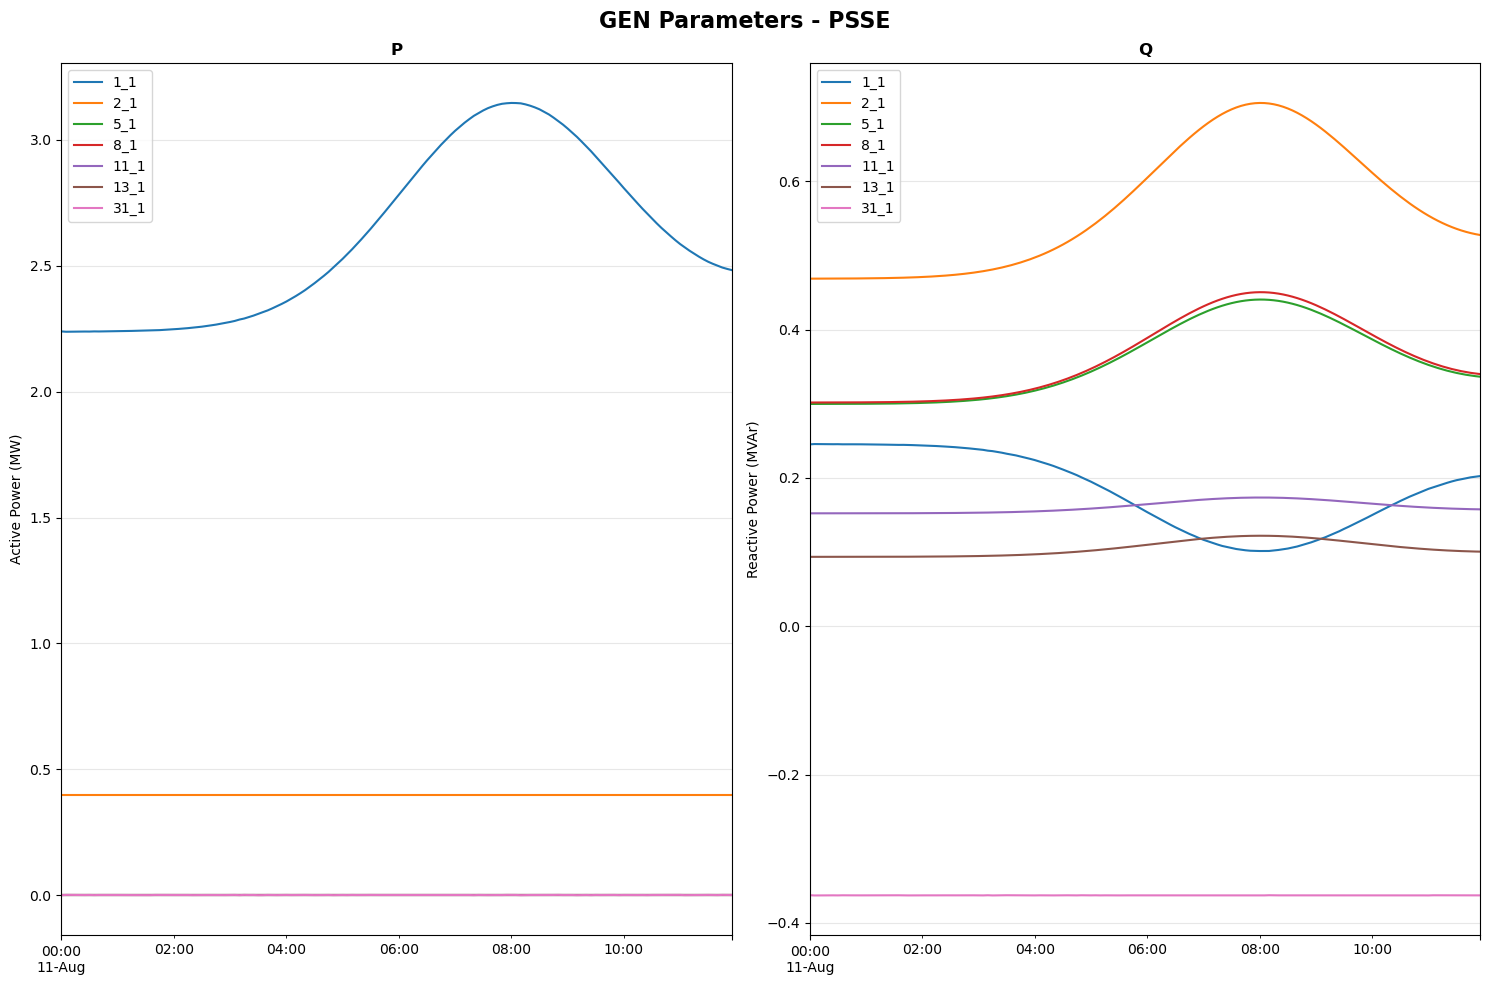

(<Figure size 1500x1000 with 2 Axes>,
 array([<AxesSubplot:title={'center':'P'}, ylabel='Active Power (MW)'>,
        <AxesSubplot:title={'center':'Q'}, ylabel='Reactive Power (MVAr)'>],
       dtype=object))

In [9]:
engine.plot.plot_component_grid("psse", "gen", ["p", "q"])

No valid components found to plot
No valid components found to plot


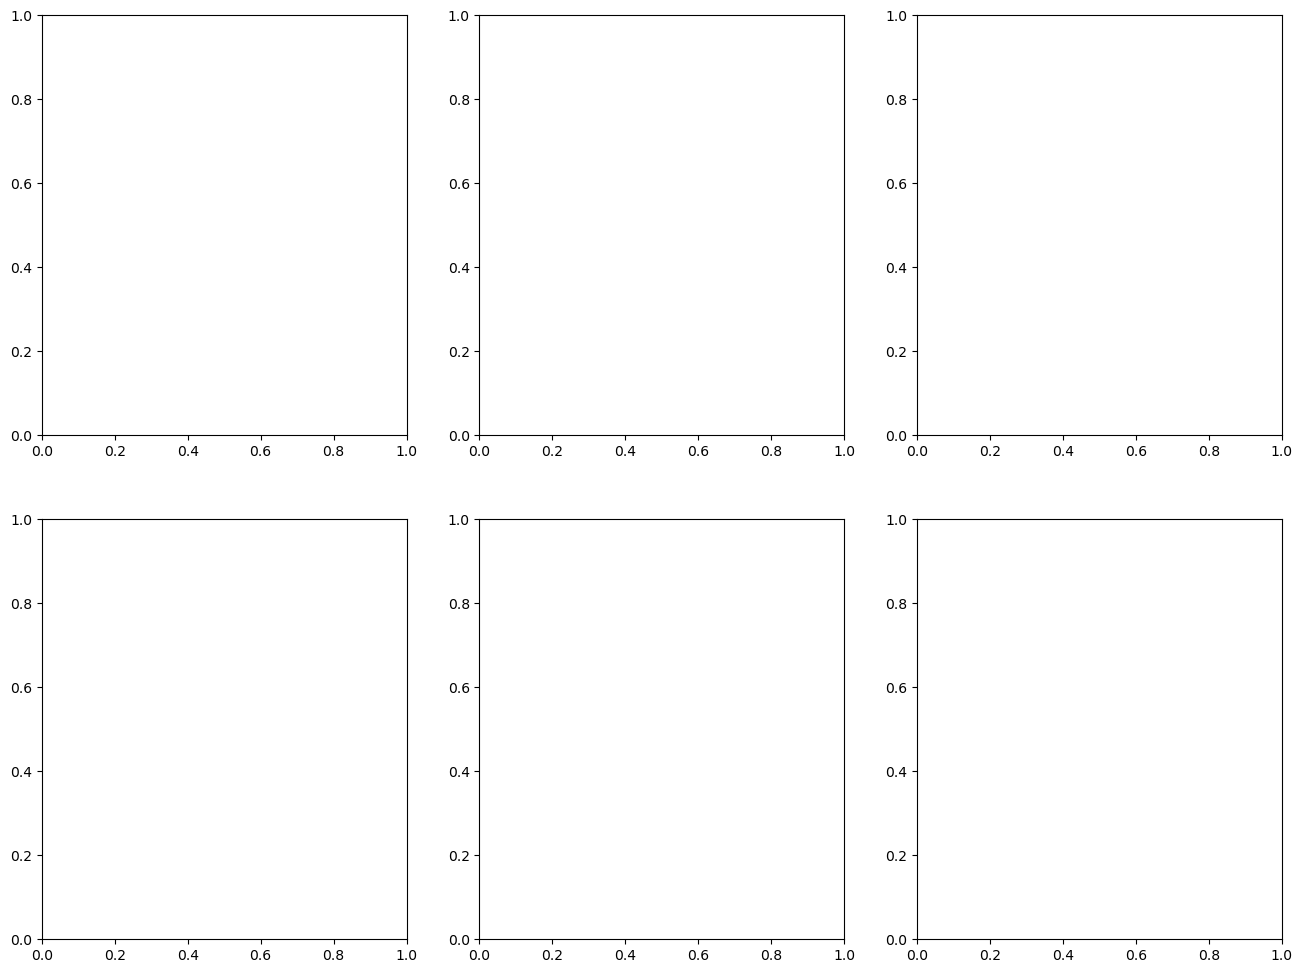

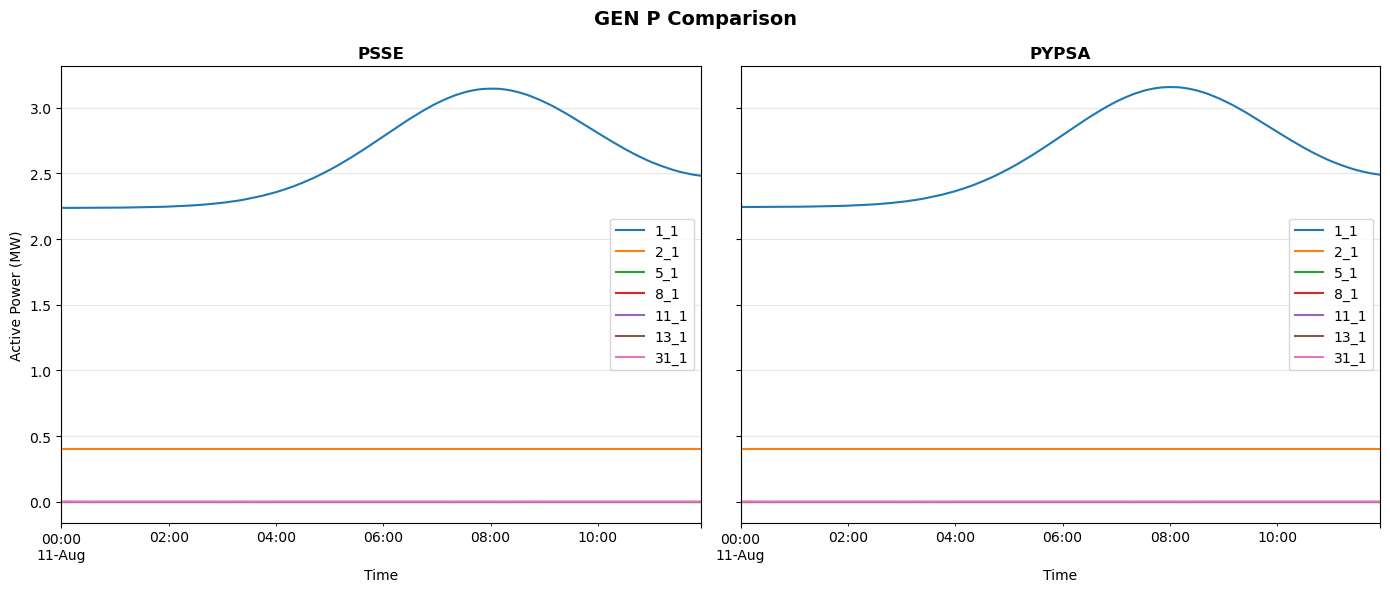

(<Figure size 1600x1200 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [11]:
engine.plot.plot_wec_analysis()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_component_data(engine, software, component_type, parameter, component_name=None, 
                       figsize=(12, 6), style='default', show_grid=True, 
                       save_path=None, **plot_kwargs):
    """
    Plot time series data for grid components from PSS®E or PyPSA simulations.
    
    Parameters:
    -----------
    engine : WecGrid.Engine
        The WecGrid engine object
    software : str
        Either "psse" or "pypsa"
    component_type : str
        Component type: "gen", "bus", "line", "load"
    parameter : str
        Parameter to plot: "p", "q", "v", etc.
    component_name : str or list, optional
        Specific component(s) to plot. If None, plots all components
    figsize : tuple
        Figure size (width, height)
    style : str
        Matplotlib style (use plt.style.available to see options)
    show_grid : bool
        Whether to show grid lines
    save_path : str, optional
        Path to save the figure
    **plot_kwargs : dict
        Additional plotting arguments (linewidth, alpha, etc.)
    """
    
    # Set style with error handling
    try:
        plt.style.use(style)
    except OSError:
        print(f"Style '{style}' not found. Using default style.")
        print(f"Available styles: {plt.style.available}")
        plt.style.use('default')
    
    # Validate inputs
    if software not in ["psse", "pypsa"]:
        raise ValueError("Software must be 'psse' or 'pypsa'")
    
    # Get the appropriate grid object
    try:
        grid_obj = getattr(engine, software).grid
    except AttributeError:
        raise ValueError(f"Engine does not have {software} attribute or grid is not loaded")
    
    # Get component data
    component_attr = f"{component_type}_t"
    if not hasattr(grid_obj, component_attr):
        raise ValueError(f"Grid object does not have {component_attr} attribute")
    
    component_data = getattr(grid_obj, component_attr)
    
    # Get parameter data
    if not hasattr(component_data, parameter):
        available_params = [attr for attr in dir(component_data) if not attr.startswith('_')]
        raise ValueError(f"Parameter '{parameter}' not found. Available: {available_params}")
    
    data = getattr(component_data, parameter)
    
    # Handle component selection
    if component_name is not None:
        if isinstance(component_name, str):
            component_name = [component_name]
        
        # Check if components exist
        missing_components = [comp for comp in component_name if comp not in data.columns]
        if missing_components:
            print(f"Warning: Components not found: {missing_components}")
            component_name = [comp for comp in component_name if comp in data.columns]
        
        if not component_name:
            print("No valid components found to plot")
            return
        
        data = data[component_name]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set default plot kwargs
    default_kwargs = {'linewidth': 2, 'alpha': 0.8}
    default_kwargs.update(plot_kwargs)
    
    # Plot the data
    if isinstance(data, pd.Series):
        ax.plot(data.index, data.values, label=data.name, **default_kwargs)
    else:
        data.plot(ax=ax, **default_kwargs)
    
    # Customize the plot
    title = f"{component_type.upper()} {parameter.upper()} - {software.upper()}"
    if component_name:
        title += f" ({', '.join(component_name) if len(component_name) <= 3 else f'{len(component_name)} components'})"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Time", fontsize=12)
    
    # Set y-label based on parameter
    ylabel_map = {
        'p': 'Active Power (pu)',
        'q': 'Reactive Power (pu)', 
        'v': 'Voltage (p.u.)',
        'line_pct': 'Line Loading (%)'
    }
    ax.set_ylabel(ylabel_map.get(parameter, parameter.upper()), fontsize=12)
    
    if show_grid:
        ax.grid(True, alpha=0.3)
    
    # Add legend if multiple components
    if isinstance(data, pd.DataFrame) and len(data.columns) > 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    return fig, ax

import matplotlib.pyplot as plt
import pandas as pd

def plot_component_data(engine, software, component_type, parameter, component_name=None, 
                       figsize=(12, 6), style='default', show_grid=True, 
                       save_path=None, **plot_kwargs):
    """
    Plot time series data for grid components from PSS®E or PyPSA simulations.
    
    Parameters:
    -----------
    engine : WecGrid.Engine
        The WecGrid engine object
    software : str
        Either "psse" or "pypsa"
    component_type : str
        Component type: "gen", "bus", "line", "load"
    parameter : str
        Parameter to plot: "p", "q", "v", etc.
    component_name : str or list, optional
        Specific component(s) to plot. If None, plots all components
    figsize : tuple
        Figure size (width, height)
    style : str
        Matplotlib style (use plt.style.available to see options)
    show_grid : bool
        Whether to show grid lines
    save_path : str, optional
        Path to save the figure
    **plot_kwargs : dict
        Additional plotting arguments (linewidth, alpha, etc.)
    """
    
    # Set style with error handling
    try:
        plt.style.use(style)
    except OSError:
        print(f"Style '{style}' not found. Using default style.")
        print(f"Available styles: {plt.style.available}")
        plt.style.use('default')
    
    # Validate inputs
    if software not in ["psse", "pypsa"]:
        raise ValueError("Software must be 'psse' or 'pypsa'")
    
    # Get the appropriate grid object
    try:
        grid_obj = getattr(engine, software).grid
    except AttributeError:
        raise ValueError(f"Engine does not have {software} attribute or grid is not loaded")
    
    # Get component data
    component_attr = f"{component_type}_t"
    if not hasattr(grid_obj, component_attr):
        raise ValueError(f"Grid object does not have {component_attr} attribute")
    
    component_data = getattr(grid_obj, component_attr)
    
    # Get parameter data
    if not hasattr(component_data, parameter):
        available_params = [attr for attr in dir(component_data) if not attr.startswith('_')]
        raise ValueError(f"Parameter '{parameter}' not found. Available: {available_params}")
    
    data = getattr(component_data, parameter)
    
    # Handle component selection
    if component_name is not None:
        if isinstance(component_name, str):
            component_name = [component_name]
        
        # Check if components exist
        missing_components = [comp for comp in component_name if comp not in data.columns]
        if missing_components:
            print(f"Warning: Components not found: {missing_components}")
            component_name = [comp for comp in component_name if comp in data.columns]
        
        if not component_name:
            print("No valid components found to plot")
            return
        
        data = data[component_name]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set default plot kwargs
    default_kwargs = {'linewidth': 2, 'alpha': 0.8}
    default_kwargs.update(plot_kwargs)
    
    # Plot the data
    if isinstance(data, pd.Series):
        ax.plot(data.index, data.values, label=data.name, **default_kwargs)
    else:
        data.plot(ax=ax, **default_kwargs)
    
    # Customize the plot
    title = f"{component_type.upper()} {parameter.upper()} - {software.upper()}"
    if component_name:
        title += f" ({', '.join(component_name) if len(component_name) <= 3 else f'{len(component_name)} components'})"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Time", fontsize=12)
    
    # Set y-label based on parameter
    ylabel_map = {
        'p': 'Active Power (pu)',
        'q': 'Reactive Power (pu)', 
        'v': 'Voltage (p.u.)',
        'line_pct': 'Line Loading (%)'
    }
    ax.set_ylabel(ylabel_map.get(parameter, parameter.upper()), fontsize=12)
    
    if show_grid:
        ax.grid(True, alpha=0.3)
    
    # Add legend if multiple components
    if isinstance(data, pd.DataFrame) and len(data.columns) > 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    return fig, ax



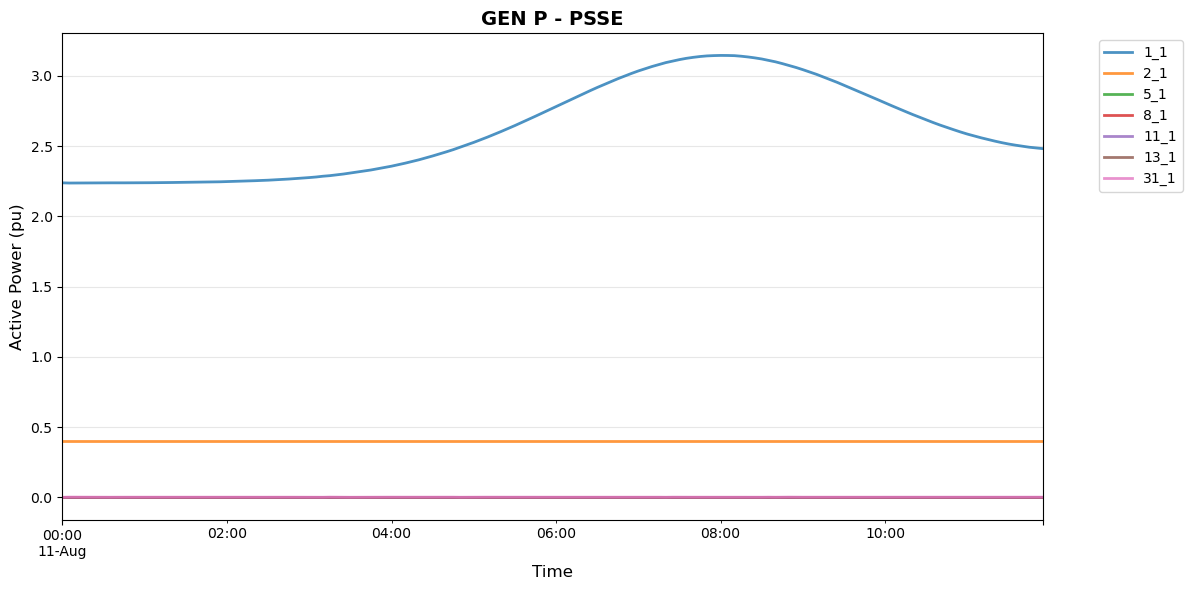

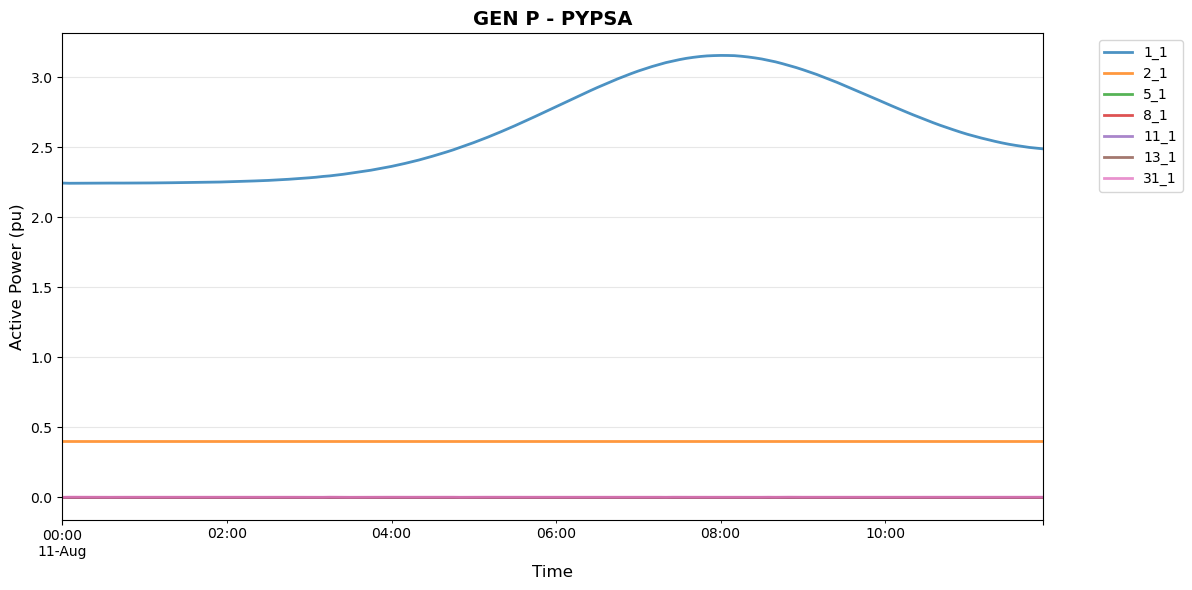

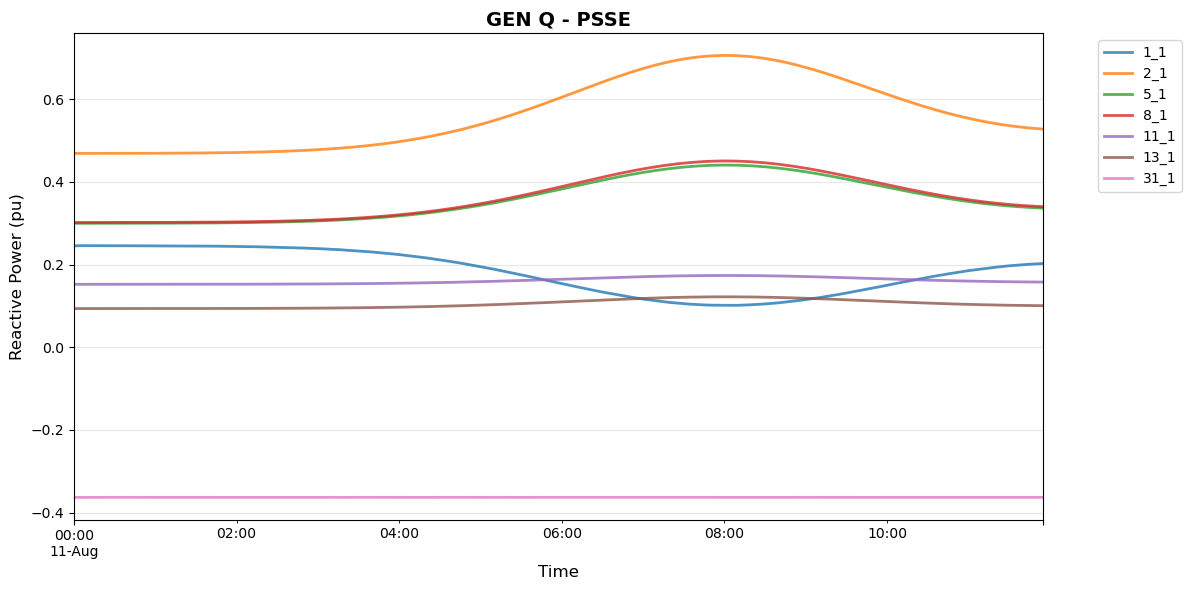

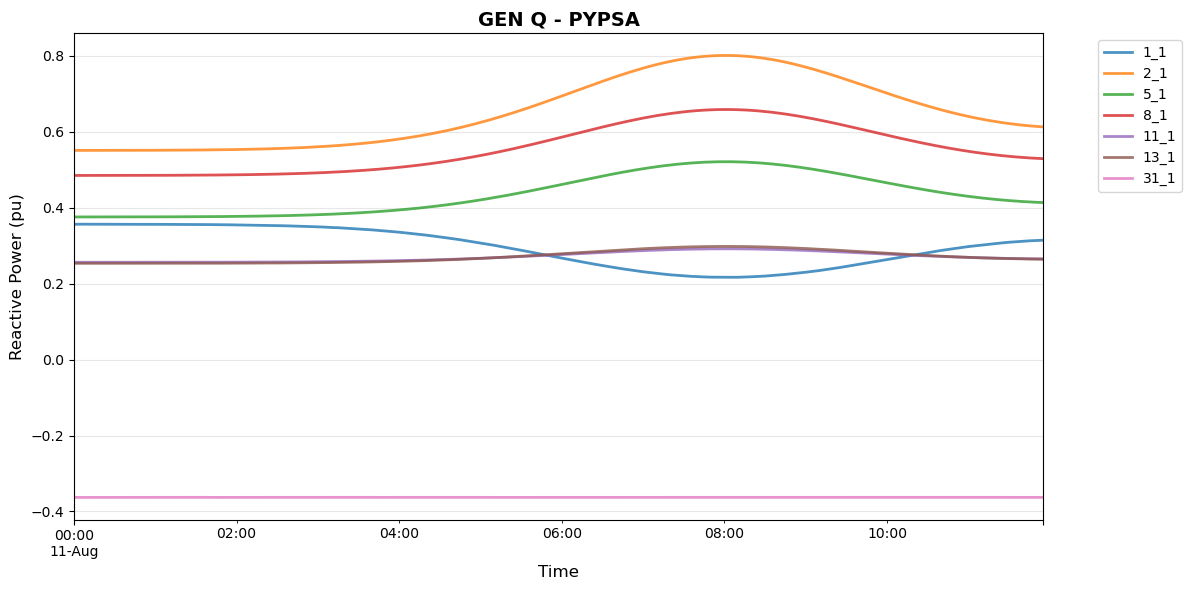

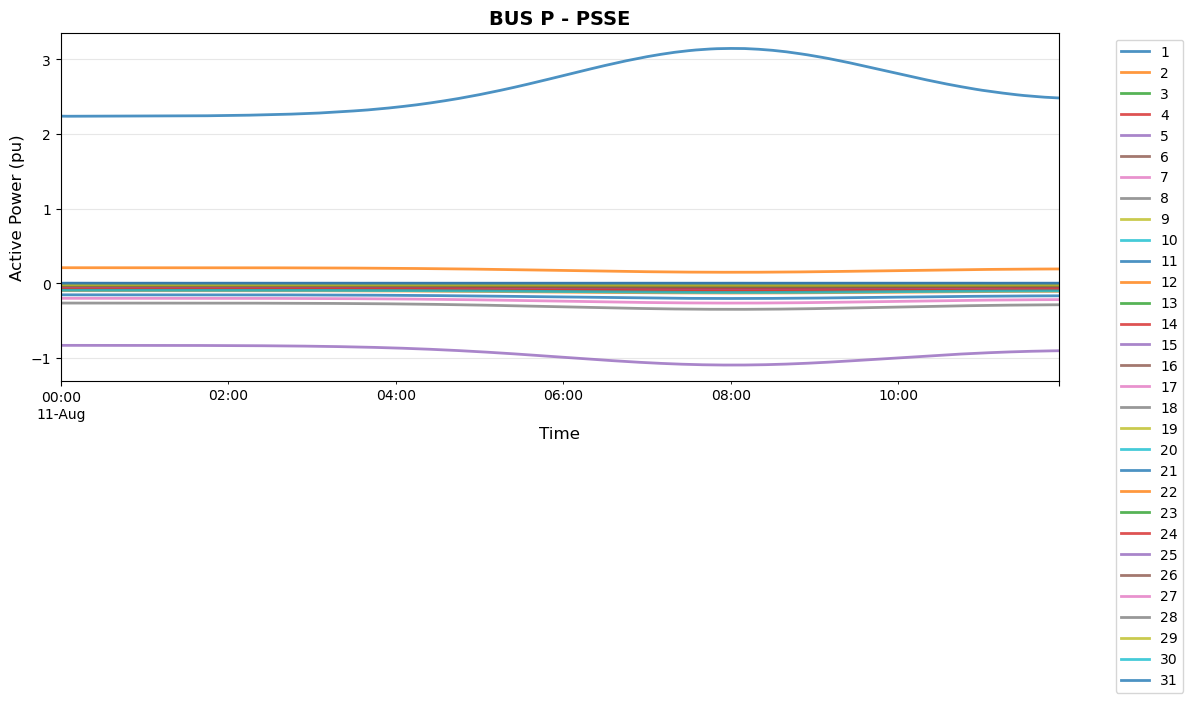

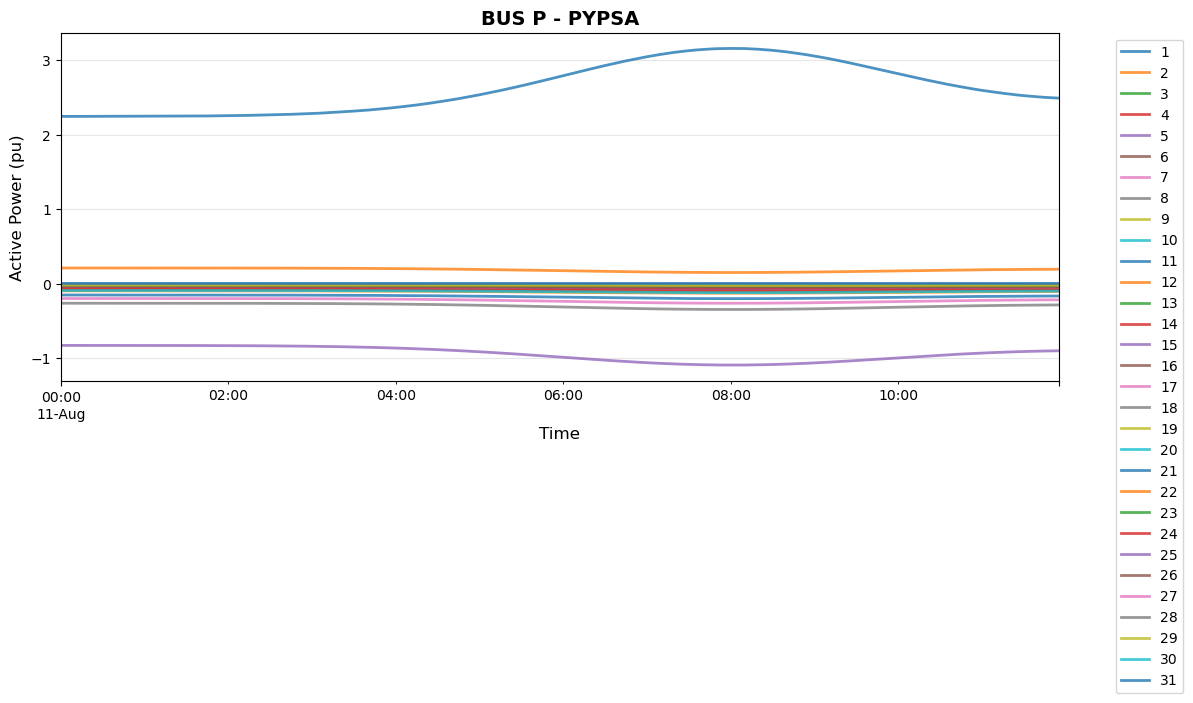

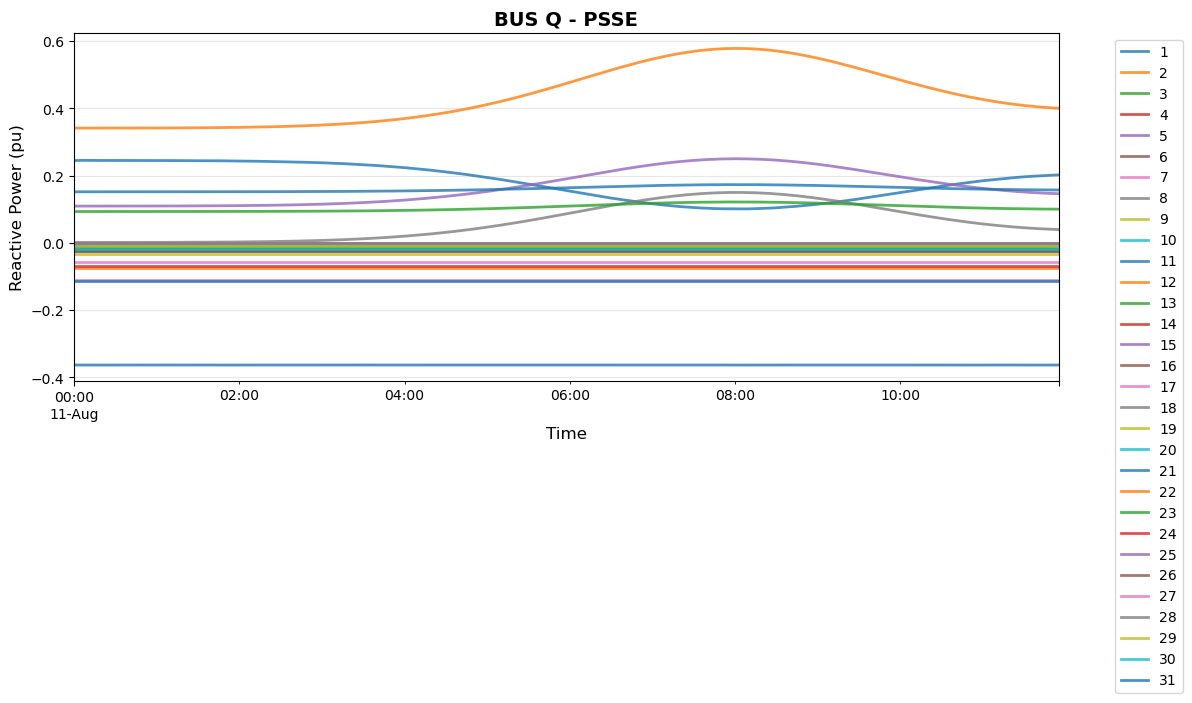

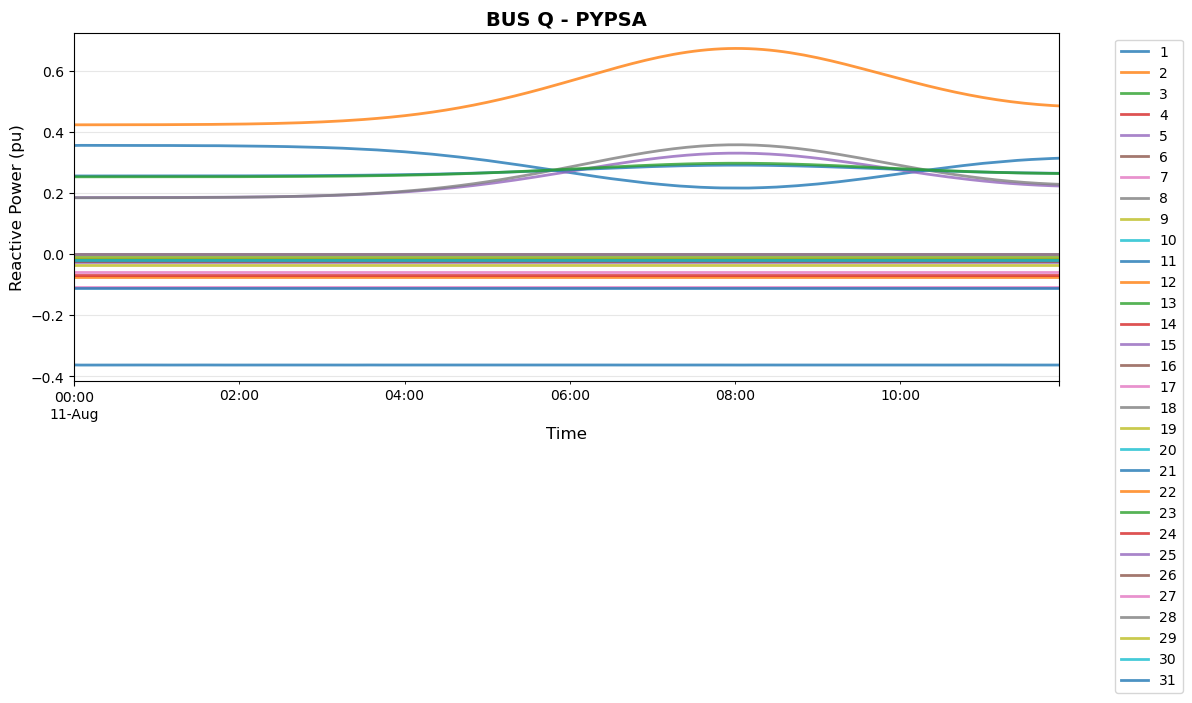

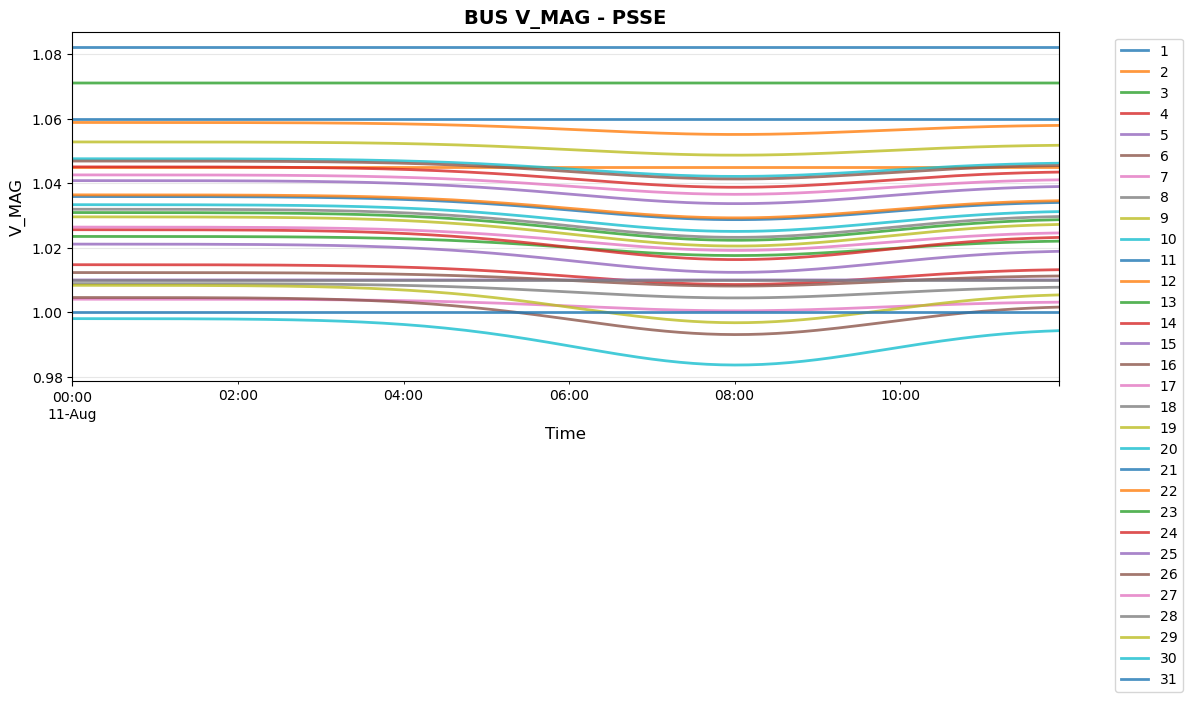

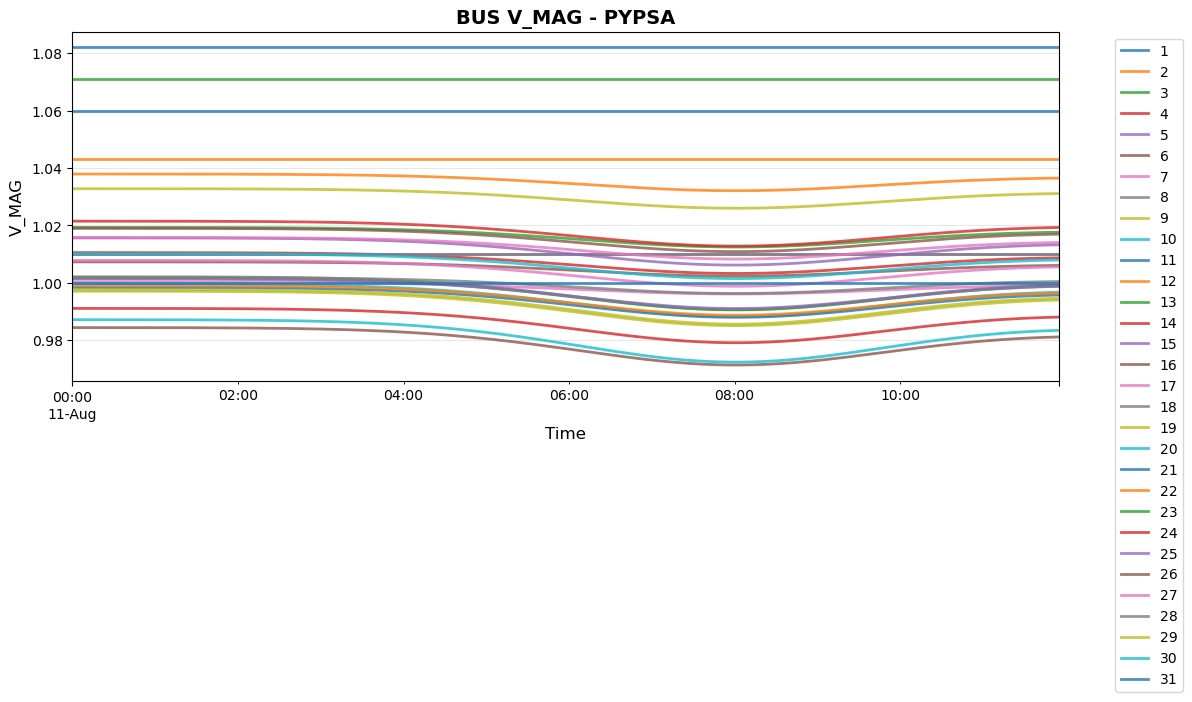

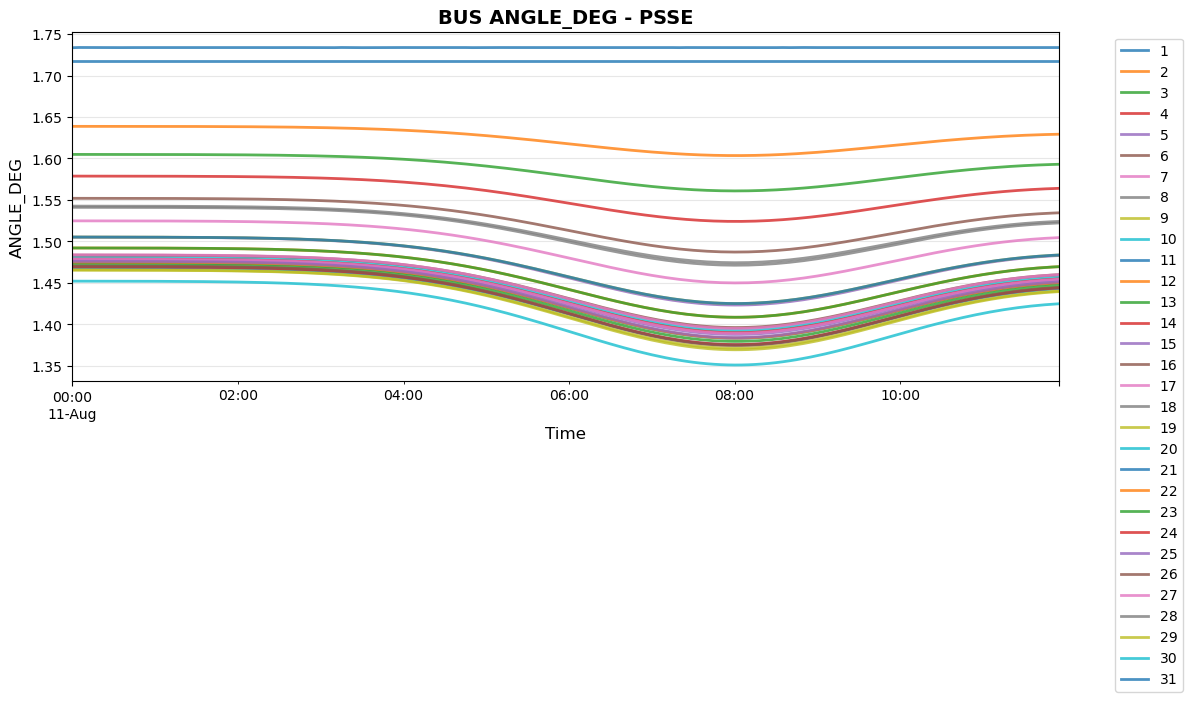

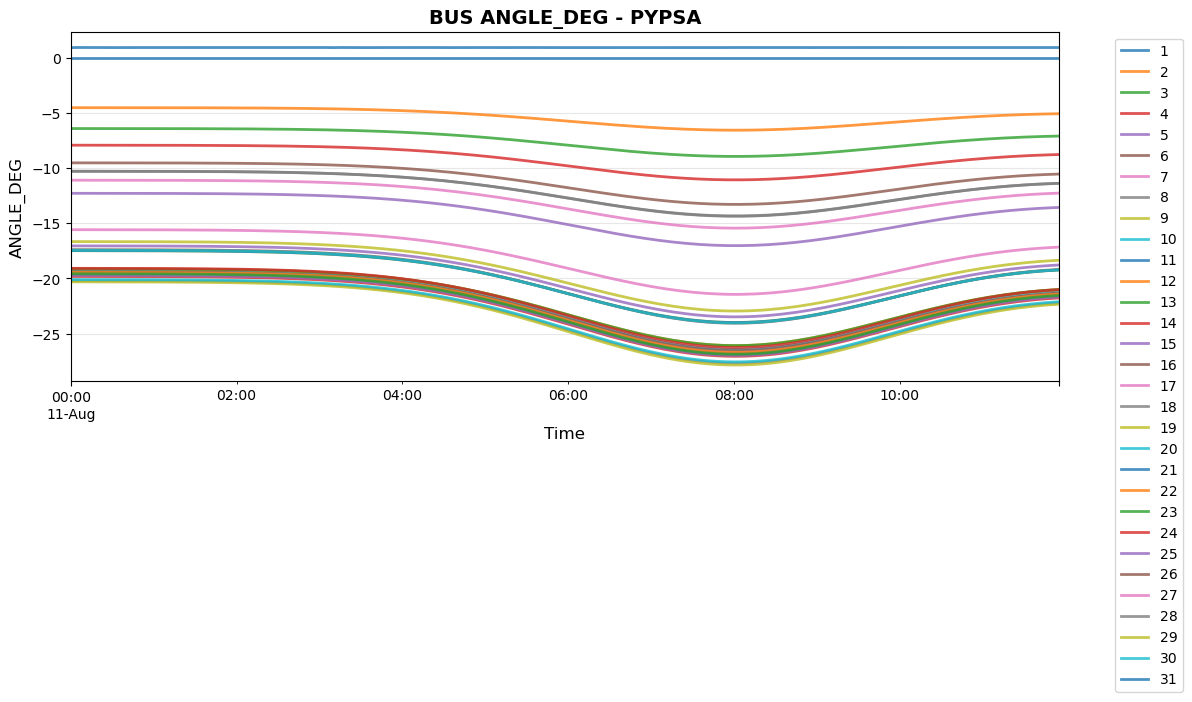

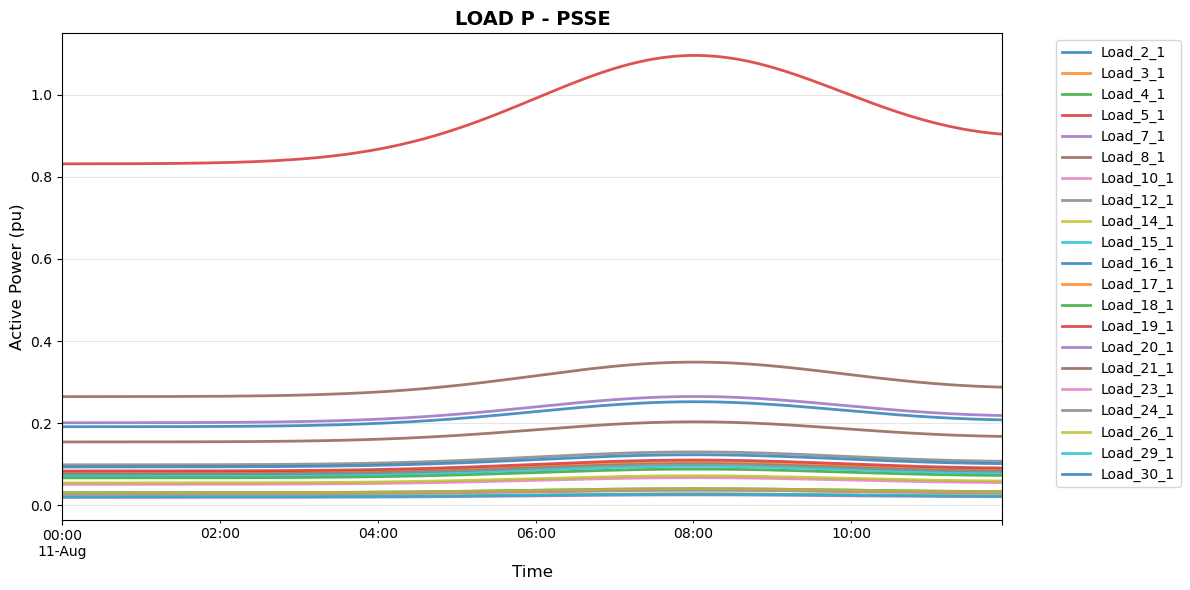

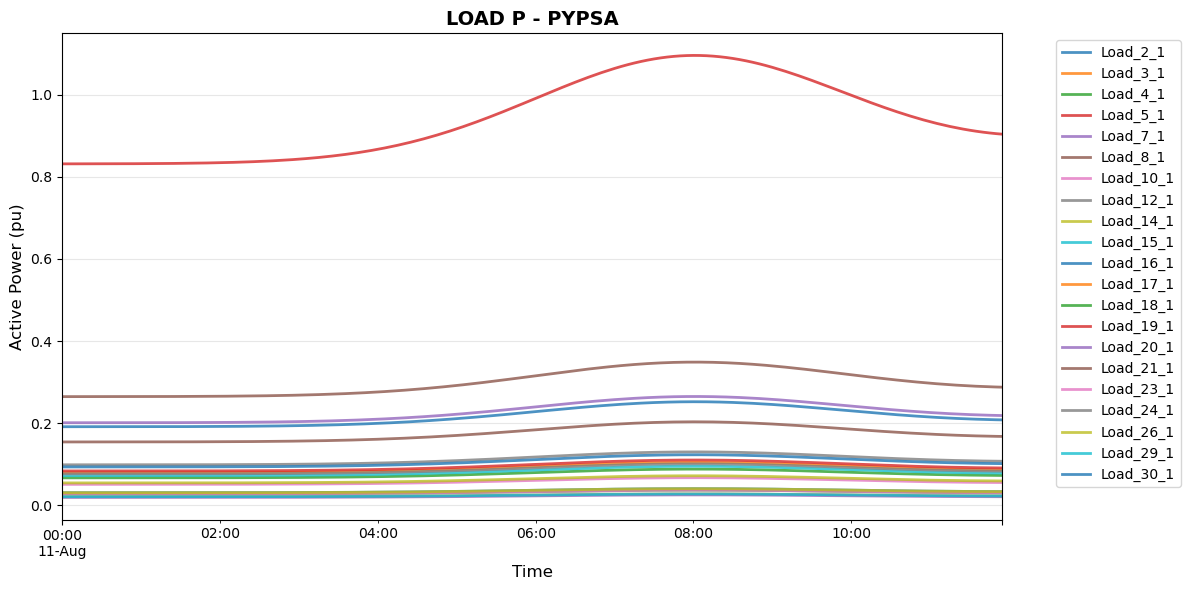

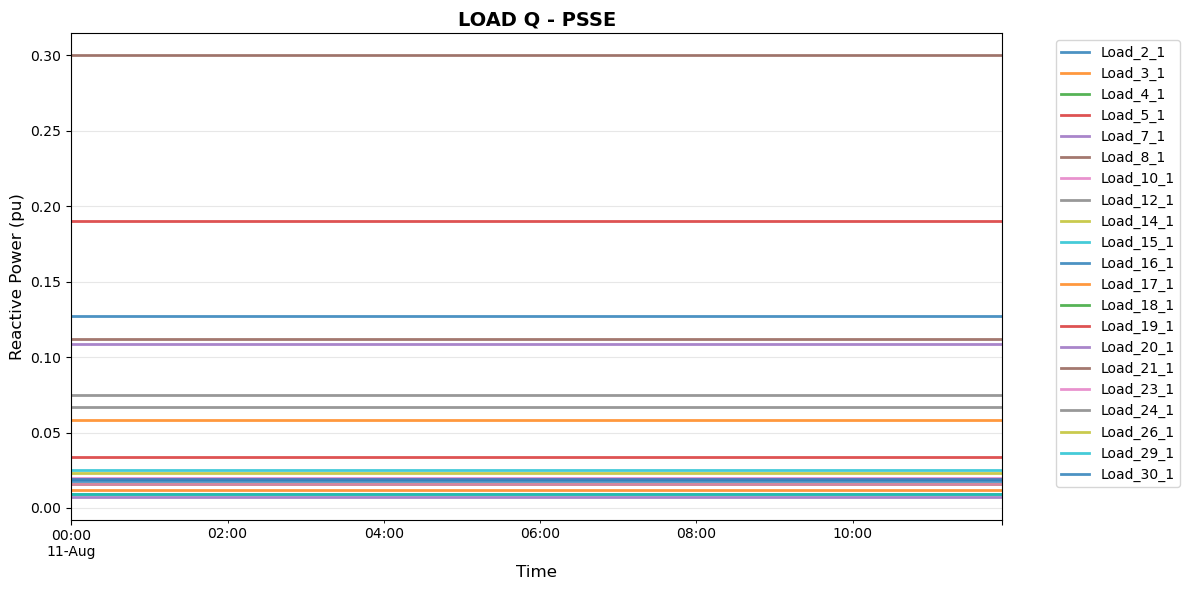

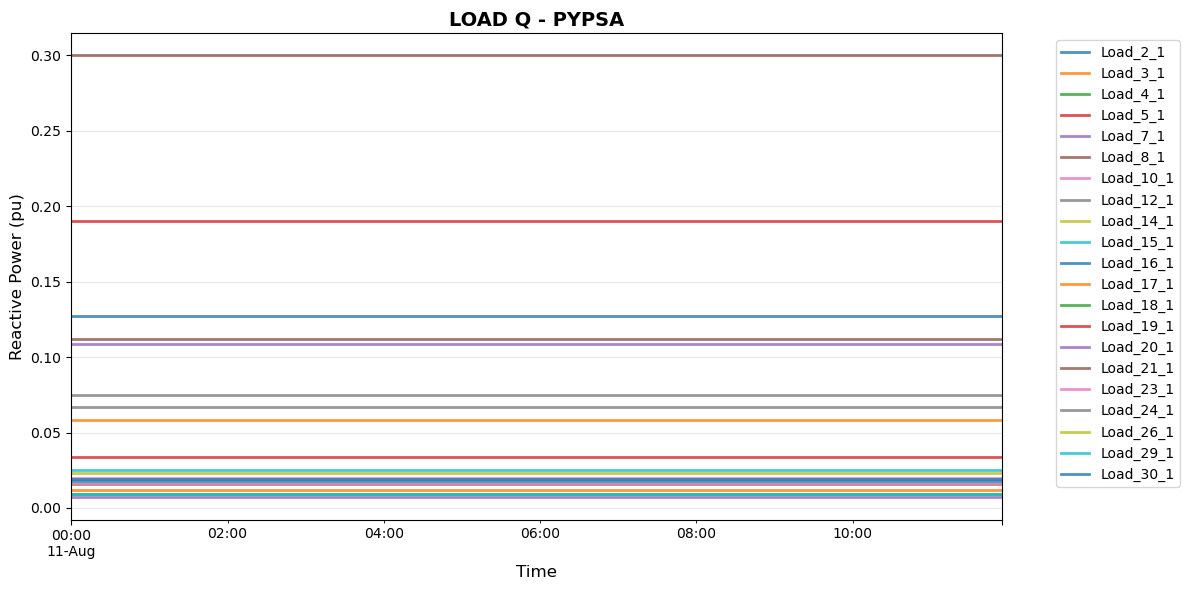

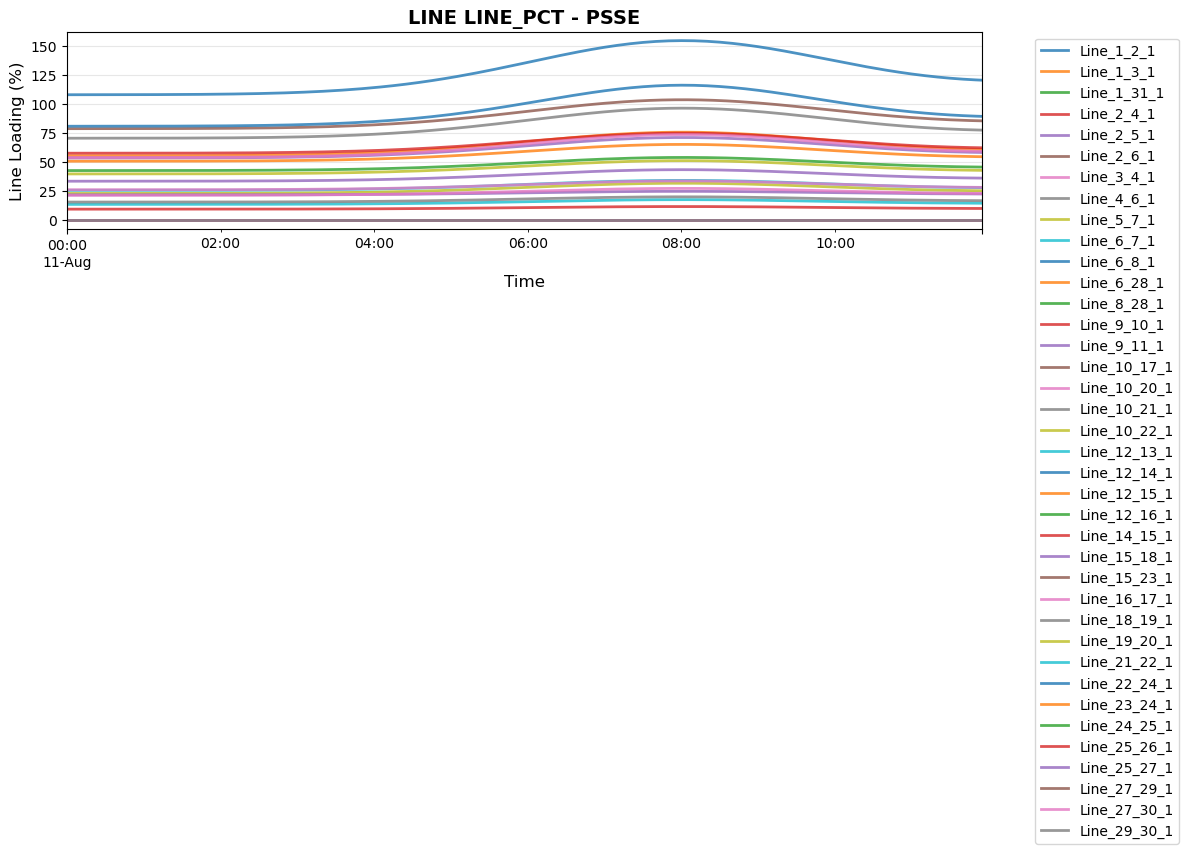

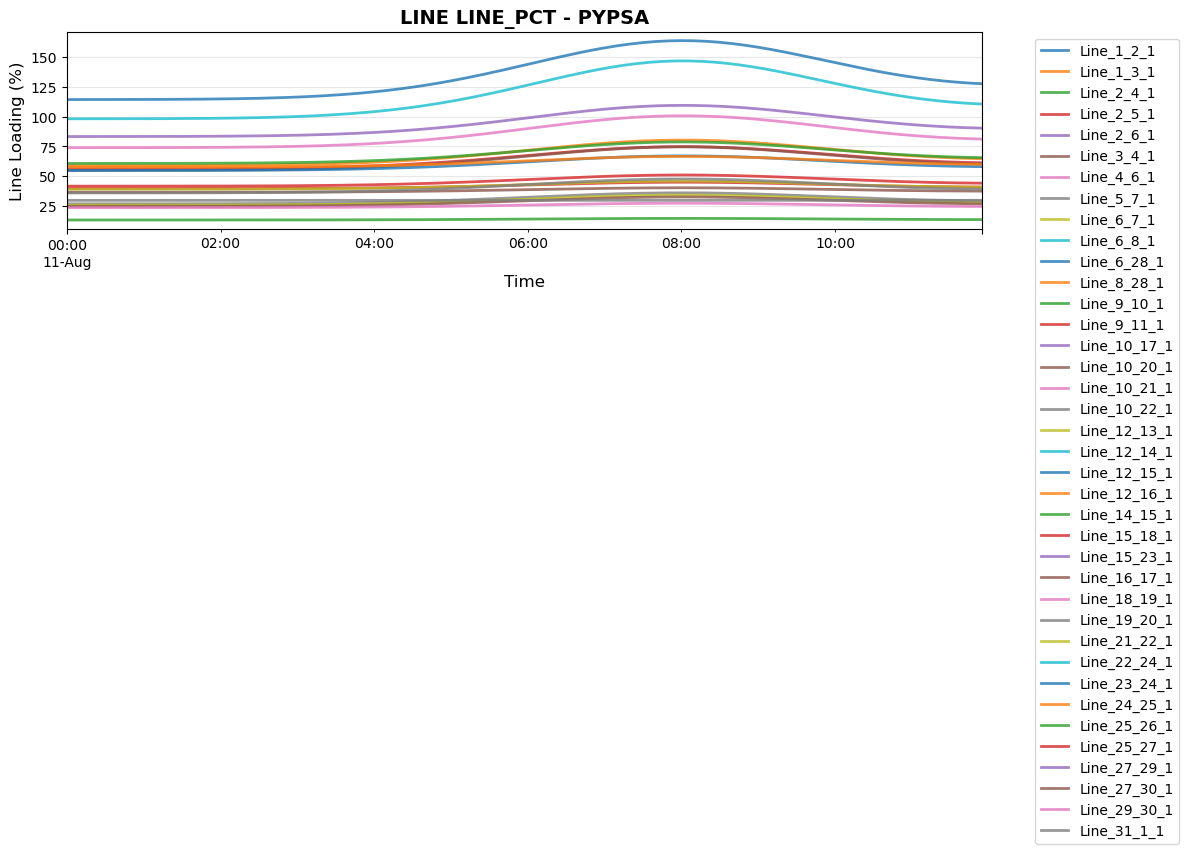

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'LINE LINE_PCT - PYPSA'}, xlabel='Time', ylabel='Line Loading (%)'>)

In [44]:
# Generator 
plot_component_data(engine, "psse", "gen", "p")
plot_component_data(engine, "pypsa", "gen", "p")
plot_component_data(engine, "psse", "gen", "q")
plot_component_data(engine, "pypsa", "gen", "q")

# bus
plot_component_data(engine, "psse", "bus", "p")
plot_component_data(engine, "pypsa", "bus", "p")
plot_component_data(engine, "psse", "bus", "q")
plot_component_data(engine, "pypsa", "bus", "q")
plot_component_data(engine, "psse", "bus", "v_mag")
plot_component_data(engine, "pypsa", "bus", "v_mag")
plot_component_data(engine, "psse", "bus", "angle_deg")
plot_component_data(engine, "pypsa", "bus", "angle_deg")

# load
plot_component_data(engine, "psse", "load", "p")
plot_component_data(engine, "pypsa", "load", "p")
plot_component_data(engine, "psse", "load", "q")
plot_component_data(engine, "pypsa", "load", "q")

#line
plot_component_data(engine, "psse", "line", "line_pct")
plot_component_data(engine, "pypsa", "line", "line_pct")

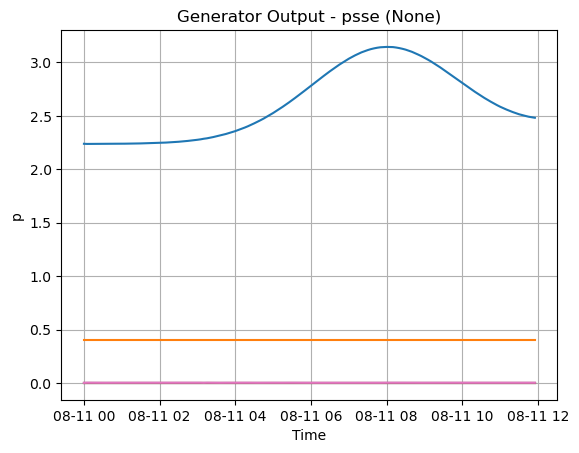

In [21]:
import matplotlib.pyplot as plt
def generator(software, parameter, component_name):
    data = None
    if software == "psse":
        data = engine.psse.grid.gen_t[parameter]
    elif software == "pypsa":
        data = engine.pypsa.grid.gen_t[parameter]

    if component_name is not None:
        data = data[component_name]
    
    plt.plot(data)
    plt.title(f"Generator Output - {software} ({component_name})")
    plt.xlabel("Time")
    plt.ylabel(parameter)
    plt.grid()
    plt.show()

generator("psse", "p", None)

In [42]:
parameter = 'p'
data = engine.psse.grid.line.keys()
data

Index(['ibus', 'jbus', 'line_pct', 'status'], dtype='object')

In [11]:
engine.pypsa.network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
G0,1,Slack,,10000.0,False,-10000.0,10000.0,-1.0,1.0,260.948,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G1,2,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,40.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G2,5,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G3,8,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G4,11,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G5,13,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
W1,31,PV,,0.0,False,0.0,inf,0.0,1.0,0.001,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [17]:
engine1 = wecgrid.Engine()
engine1.case("IEEE30")
engine1.load(["psse", "pypsa"]) 

engine1.simulate(load_curve=True)

INFO:pssepath.core:psspath has already added PSSBIN to the system, continuing.


PSS®E software initialized
PyPSA software initialized


PyPSA Simulating: 100%|██████████| 288/288 [01:23<00:00,  3.47step/s]


In [39]:
engine.psse.grid.load.keys()

Index(['bus', 'p', 'q', 'base', 'status'], dtype='object')

In [ ]:
engine.psse.psspy.amachint(string=['NUMBER','IREG'])

(6, None)

In [4]:
engine.psse.grid.gen_t.p

,1_1,2_1,5_1,8_1,11_1,13_1
2025-08-11,2.60957,0.4,0.0,0.0,0.0,0.0


<AxesSubplot:>

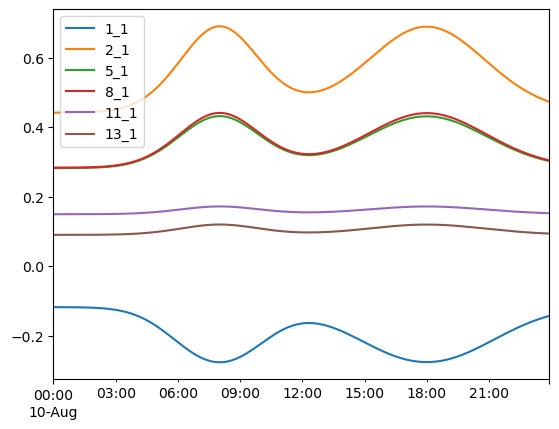

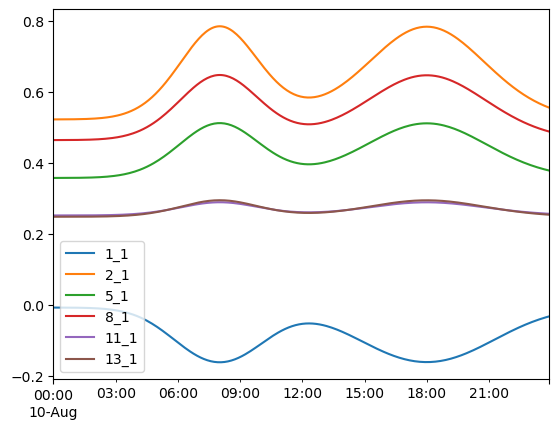

In [3]:
# engine1.psse.grid.gen_t.p.plot()
# engine1.pypsa.grid.gen_t.p.plot()
engine.psse.grid.gen_t.q.plot()
engine.pypsa.grid.gen_t.q.plot()

In [15]:
engine.pypsa.network.loads.p_set

Load
L0     21.7
L1      2.4
L2      7.6
L3     94.2
L4     22.8
L5     30.0
L6      5.8
L7     11.2
L8      6.2
L9      8.2
L10     3.5
L11     9.0
L12     3.2
L13     9.5
L14     2.2
L15    17.5
L16     3.2
L17     8.7
L18     3.5
L19     2.4
L20    10.6
Name: p_set, dtype: float64

In [19]:
engine.pypsa.network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
L0,2,AC,,21.7,12.7,-1.0
L1,3,AC,,2.4,1.2,-1.0
L2,4,AC,,7.6,1.6,-1.0
L3,5,AC,,94.2,19.0,-1.0
L4,7,AC,,22.8,10.9,-1.0
L5,8,AC,,30.0,30.0,-1.0
L6,10,AC,,5.8,2.0,-1.0
L7,12,AC,,11.2,7.5,-1.0
L8,14,AC,,6.2,1.6,-1.0


In [17]:
engine.generate_load_curves()

,2,3,4,5,7,8,10,12,14,15,...,17,18,19,20,21,23,24,26,29,30
2025-08-10 00:00:00,0.108536,0.012004,0.038013,0.471158,0.114038,0.150050,0.029010,0.056019,0.031010,0.041014,...,0.045015,0.016005,0.047516,0.011004,0.087529,0.016005,0.043515,0.017506,0.012004,0.053018
2025-08-10 00:05:00,0.108543,0.012005,0.038015,0.471186,0.114045,0.150059,0.029011,0.056022,0.031012,0.041016,...,0.045018,0.016006,0.047519,0.011004,0.087535,0.016006,0.043517,0.017507,0.012005,0.053021
2025-08-10 00:10:00,0.108551,0.012006,0.038018,0.471220,0.114053,0.150070,0.029014,0.056026,0.031014,0.041019,...,0.045021,0.016007,0.047522,0.011005,0.087541,0.016007,0.043520,0.017508,0.012006,0.053025
2025-08-10 00:15:00,0.108560,0.012007,0.038021,0.471258,0.114063,0.150082,0.029016,0.056031,0.031017,0.041022,...,0.045025,0.016009,0.047526,0.011006,0.087548,0.016009,0.043524,0.017510,0.012007,0.053029
2025-08-10 00:20:00,0.108570,0.012008,0.038024,0.471303,0.114073,0.150097,0.029019,0.056036,0.031020,0.041026,...,0.045029,0.016010,0.047531,0.011007,0.087556,0.016010,0.043528,0.017511,0.012008,0.053034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-10 23:35:00,0.110704,0.012244,0.038772,0.480565,0.116315,0.153046,0.029589,0.057137,0.031630,0.041833,...,0.045914,0.016325,0.048465,0.011223,0.089277,0.016325,0.044383,0.017855,0.012244,0.054076
2025-08-10 23:40:00,0.110460,0.012217,0.038686,0.479508,0.116059,0.152709,0.029524,0.057012,0.031560,0.041741,...,0.045813,0.016289,0.048358,0.011199,0.089081,0.016289,0.044286,0.017816,0.012217,0.053957
2025-08-10 23:45:00,0.110240,0.012192,0.038609,0.478554,0.115828,0.152406,0.029465,0.056898,0.031497,0.041658,...,0.045722,0.016257,0.048262,0.011176,0.088903,0.016257,0.044198,0.017781,0.012192,0.053850
2025-08-10 23:50:00,0.110042,0.012171,0.038540,0.477695,0.115620,0.152132,0.029412,0.056796,0.031441,0.041583,...,0.045640,0.016227,0.048175,0.011156,0.088744,0.016227,0.044118,0.017749,0.012171,0.053753


In [ ]:
engine.psse.load

,bus,p,q,base,status
load,,,,,
Load_2_0,2,0.217,0.127,132.0,1
Load_3_0,3,0.024,0.012,132.0,1
Load_4_0,4,0.076,0.016,132.0,1
Load_5_0,5,0.942,0.190,132.0,1
Load_7_0,7,0.228,0.109,132.0,1
Load_8_0,8,0.300,0.300,132.0,1
Load_10_0,10,0.058,0.020,33.0,1
Load_12_0,12,0.112,0.075,33.0,1
Load_14_0,14,0.062,0.016,33.0,1


In [26]:
engine.wec_farms[0].power_at_snapshot(timestamp=engine.time.snapshots[0])

0.008457722614067437

In [37]:
engine.pypsa.network.loads["bus"]

Load
L0      2
L1      3
L2      4
L3      5
L4      7
L5      8
L6     10
L7     12
L8     14
L9     15
L10    16
L11    17
L12    18
L13    19
L14    20
L15    21
L16    23
L17    24
L18    26
L19    29
L20    30
Name: bus, dtype: object

In [ ]:
engine.pypsa.network.buses.columns

Index(['v_nom', 'type', 'x', 'y', 'carrier', 'unit', 'v_mag_pu_set',
       'v_mag_pu_min', 'v_mag_pu_max', 'control', 'sub_network', 'generator'],
      dtype='object', name='attribute')

In [3]:
engine.apply_wec(farm_name="WEC-FARM", size = 1, sim_id=2, bus_location=31, connecting_bus=1, model="RM3")

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.045347 seconds


Starting MATLAB engine...
MATLAB engine started and WEC-SIM path added...
Starting WEC-SIM simulation...
simulation complete... writing to database
WEC-SIM complete: model = RM3, ID = 2, duration = 43200s
MATLAB engine stopped.


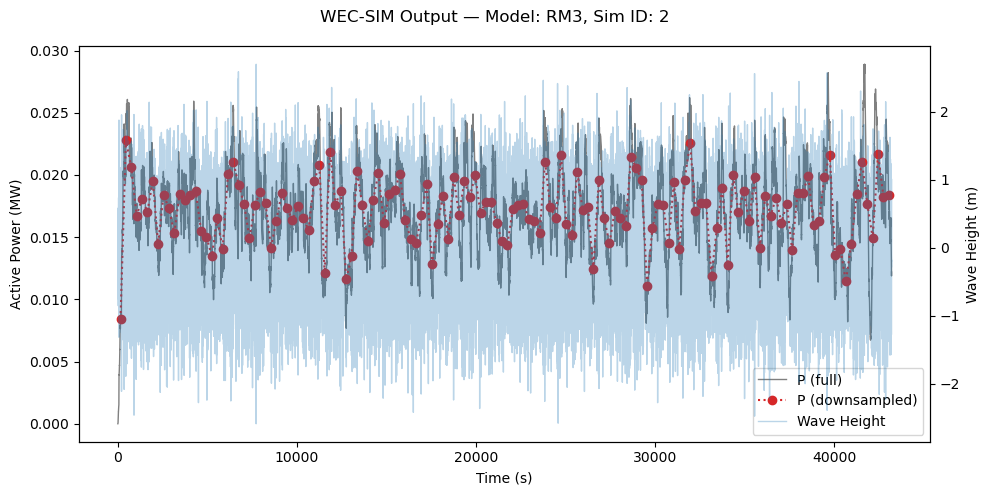

True

In [ ]:
#engine.wec_sim(sim_id=2, model="RM3"). 

In [2]:
engine.apply_wec(farm_name="WEC-FARM", size = 1, sim_id=2, bus_location=31, connecting_bus=1, model="RM3")

In [3]:
engine.simulate(load_curve=True)

Simulating:   0%|          | 0/144 [00:00<?, ?step/s]

Simulating: 100%|██████████| 144/144 [00:03<00:00, 37.35step/s]


In [ ]:
engine.wec_farms[0].wec_devices[0].dataframe_full

,time,p,q,base,eta
0,0.0,0.000000e+00,0.0,1.0,0.349918
1,0.1,3.342286e-09,0.0,1.0,0.271829
2,0.2,1.864300e-08,0.0,1.0,0.187037
3,0.3,5.832913e-08,0.0,1.0,0.097629
4,0.4,1.363197e-07,0.0,1.0,0.006283
...,...,...,...,...,...
35996,3599.6,1.772931e-02,0.0,1.0,0.049120
35997,3599.7,1.769936e-02,0.0,1.0,0.075164
35998,3599.8,1.767148e-02,0.0,1.0,0.097257
35999,3599.9,1.764587e-02,0.0,1.0,0.115020


In [2]:
engine.wec_sim(sim_id=81, model="RM3")

Starting MATLAB engine...
MATLAB engine started and WEC-SIM path added...
WEC-SIM complete: model=RM3, ID=81
MATLAB engine stopped.


True

In [2]:
engine.psse.state.load

,base,bus,load,p,q,status
0,132.0,2,Load_2_0,0.164394,0.096212,1
1,132.0,3,Load_3_0,0.018182,0.009091,1
2,132.0,4,Load_4_0,0.057576,0.012121,1
3,132.0,5,Load_5_0,0.713636,0.143939,1
4,132.0,7,Load_7_0,0.172727,0.082576,1
5,132.0,8,Load_8_0,0.227273,0.227273,1
6,33.0,10,Load_10_0,0.175758,0.060606,1
7,33.0,12,Load_12_0,0.339394,0.227273,1
8,33.0,14,Load_14_0,0.187879,0.048485,1
9,33.0,15,Load_15_0,0.248485,0.075758,1


In [3]:
engine.psse.state.line

,ibus,jbus,line,line_pct,status
0,1,2,Line_1_2_0,126.659653,1
1,1,3,Line_1_3_0,63.744675,1
2,2,4,Line_2_4_0,64.598465,1
3,2,5,Line_2_5_0,60.765957,1
4,2,6,Line_2_6_0,88.990562,1
5,3,4,Line_3_4_0,62.011822,1
6,4,6,Line_4_6_0,81.238983,1
7,5,7,Line_5_7_0,26.628374,1
8,6,7,Line_6_7_0,29.112637,1
9,6,8,Line_6_8_0,94.812935,1


In [4]:
engine.apply_wec(farm_name="WEC-FARM", size = 8, sim_id=1, bus_location=31, connecting_bus=1, model="RM3")

In [11]:
engine.wec_farms[0].wec_devices[0]

WECDevice:
    ├─ name: 'RM3_1_0'
    ├─ model: 'RM3'
    ├─ bus_location: 31
    ├─ sim_id: 1
    ├─ MBASE: 0.1
    └─ rows: 288
    

In [ ]:
engine.pypsa.grid.

{'bus_name':                      1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26  \
 2025-08-10 00:00:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 00:05:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 00:10:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 00:15:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 00:20:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 ...                 .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..   
 2025-08-10 11:35:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 11:40:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 11:45:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 11:50:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 2025-08-10 11:55:00  1  2  3  4  5  6  7  8  9  10  ...  22  23  24  25  26   
 
                      27  

In [5]:
engine.psse.grid.gen_t.p

,1_1,2_1,5_1,8_1,11_1,13_1,31_W1
2025-08-10 00:00:00,-0.359291,0.4,0.0,0.0,0.0,0.0,0.084577
2025-08-10 00:05:00,-0.359304,0.4,0.0,0.0,0.0,0.0,0.227916
2025-08-10 00:10:00,-0.35928,0.4,0.0,0.0,0.0,0.0,0.206039
2025-08-10 00:15:00,-0.35924,0.4,0.0,0.0,0.0,0.0,0.167328
2025-08-10 00:20:00,-0.359252,0.4,0.0,0.0,0.0,0.0,0.181047
...,...,...,...,...,...,...,...
2025-08-10 11:35:00,-0.354651,0.4,0.0,0.0,0.0,0.0,0.176401
2025-08-10 11:40:00,-0.354932,0.4,0.0,0.0,0.0,0.0,0.149419
2025-08-10 11:45:00,-0.355287,0.4,0.0,0.0,0.0,0.0,0.216797
2025-08-10 11:50:00,-0.355521,0.4,0.0,0.0,0.0,0.0,0.182494


In [11]:
engine.wec_farms[0].wec_devices[0]

WECDevice:
    ├─ name: 'RM3_2_0'
    ├─ model: 'RM3'
    ├─ bus_location: 31
    ├─ sim_id: 2
    ├─ base: 1.0 MW
    └─ rows: 144
    

In [13]:
engine.pypsa.network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
G0,1,Slack,,10000.00,False,-10000.0,10000.00,-1.0,1.0,260.948,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G1,2,PV,,10000.00,False,-10000.0,10000.00,-1.0,1.0,40.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G2,5,PV,,10000.00,False,-10000.0,10000.00,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G3,8,PV,,10000.00,False,-10000.0,10000.00,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G4,11,PV,,10000.00,False,-10000.0,10000.00,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G5,13,PV,,10000.00,False,-10000.0,10000.00,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
W1,31,PV,,0.03,False,0.0,0.03,0.0,1.0,0.001,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [6]:
engine.pypsa.network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
G0,1,Slack,,10000.0,False,-10000.0,10000.0,-1.0,1.0,260.948,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G1,2,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,40.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G2,5,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G3,8,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G4,11,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
G5,13,PV,,10000.0,False,-10000.0,10000.0,-1.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
W1,31,PV,,0.0,False,0.0,inf,0.0,1.0,0.000,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


<AxesSubplot:>

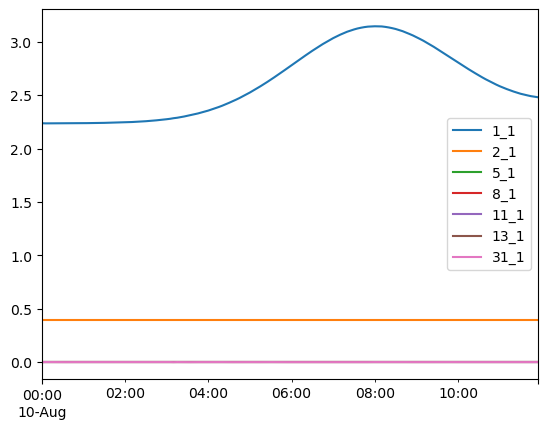

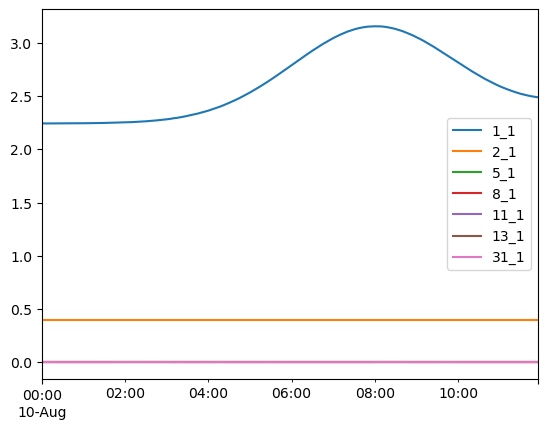

In [13]:
engine.psse.grid.gen_t.p.plot()
engine.pypsa.grid.gen_t.p.plot()

<AxesSubplot:>

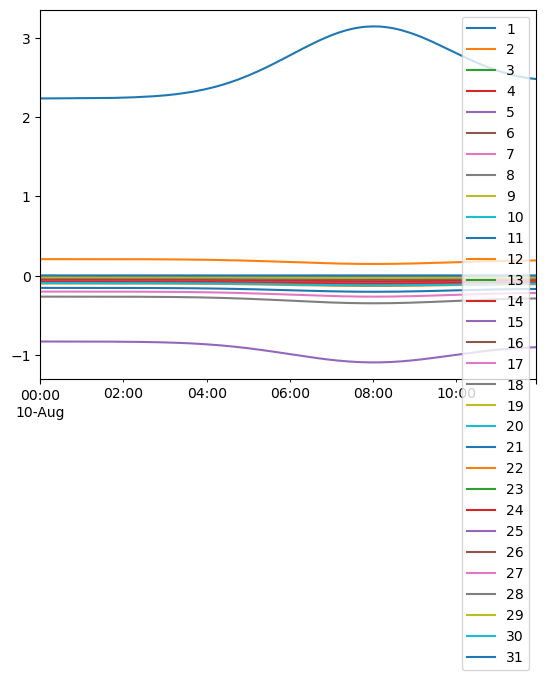

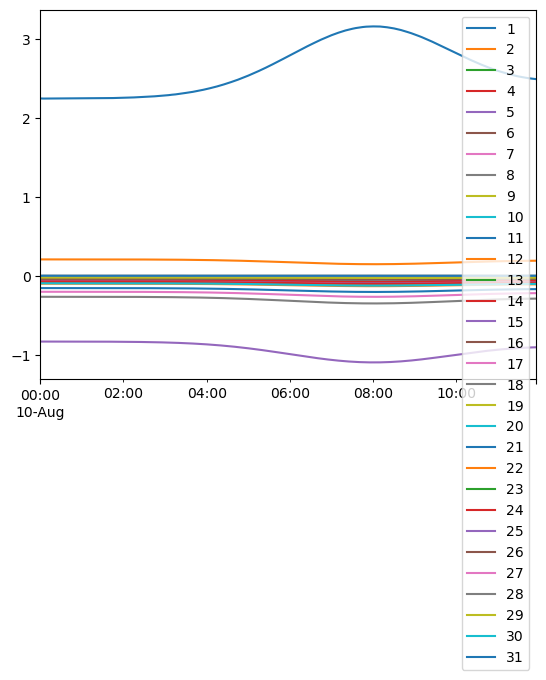

In [14]:
engine.psse.grid.bus_t.p.plot()
engine.pypsa.grid.bus_t.p.plot()

<AxesSubplot:>

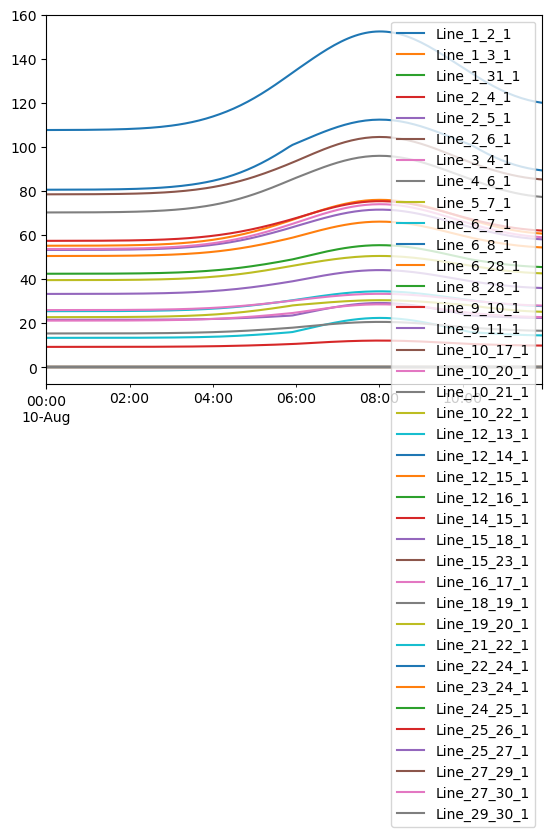

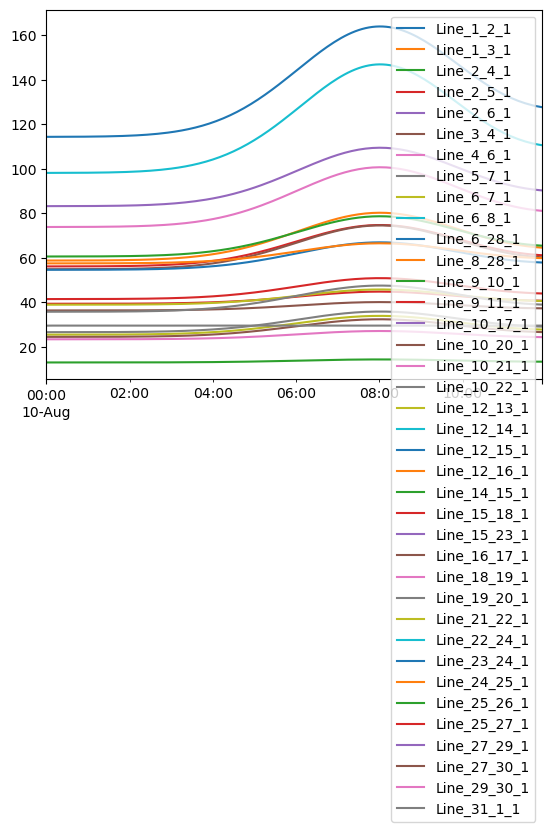

In [15]:
engine.psse.grid.line_t.line_pct.plot()
engine.pypsa.grid.line_t.line_pct.plot()

In [9]:
engine.psse.load

,bus,p,q,base,status
load,,,,,
Load_2_1,2,0.208118,0.127,100.0,1
Load_3_1,3,0.023018,0.012,100.0,1
Load_4_1,4,0.072889,0.016,100.0,1
Load_5_1,5,0.903443,0.190,100.0,1
Load_7_1,7,0.218668,0.109,100.0,1
Load_8_1,8,0.287721,0.300,100.0,1
Load_10_1,10,0.055626,0.020,100.0,1
Load_12_1,12,0.107416,0.075,100.0,1
Load_14_1,14,0.059462,0.016,100.0,1


In [10]:
engine.pypsa.load

,bus,p,q,base,status
load,,,,,
Load_2_1,2,0.208118,0.127,100.0,1
Load_3_1,3,0.023018,0.012,100.0,1
Load_4_1,4,0.072889,0.016,100.0,1
Load_5_1,5,0.903443,0.190,100.0,1
Load_7_1,7,0.218668,0.109,100.0,1
Load_8_1,8,0.287721,0.300,100.0,1
Load_10_1,10,0.055626,0.020,100.0,1
Load_12_1,12,0.107416,0.075,100.0,1
Load_14_1,14,0.059462,0.016,100.0,1


In [18]:
engine.pypsa.network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
L0,2,AC,,12.550890,12.7,-1.0
L1,3,AC,,1.388117,1.2,-1.0
L2,4,AC,,4.395703,1.6,-1.0
L3,5,AC,,54.483582,19.0,-1.0
L4,7,AC,,13.187109,10.9,-1.0
L5,8,AC,,17.351461,30.0,-1.0
L6,10,AC,,3.354616,2.0,-1.0
L7,12,AC,,6.477878,7.5,-1.0
L8,14,AC,,3.585968,1.6,-1.0
